## set up notebook

In [1]:
#reload when modified
%load_ext autoreload
%autoreload 2
#activate r magic
%load_ext rpy2.ipython
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utilities as UT
import missingno as msno
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches


random.seed(1976)
np.random.seed(1976)

# Data Anaylsis

## Experiment SetUp

In [3]:
from IPython.display import Image
#Image(filename='images/Picture 1.png') 

 <img src="images/Slide1.jpeg" width="800" height="800" />

In [4]:
#create a dictionary of gene to desc
#from the gff file
def make_desc(_GFF=os.path.join('genomes','tb927_3','tb927_3.gff')):

    gff =pd.read_csv( _GFF, sep='\t', header=None, comment='#')
    
    gff = gff[gff.iloc[:,2]=='gene']
    #print( gff[gff[gff.columns[-1]].str.contains('Tb427_020006200')] )
    desc = {}
    for n in gff.iloc[:,-1]:
        n=n.replace('%2C',' ')
        item_list = n.split(';')
        #print (item_list)
        temp_dict = {}
        for m in item_list:
            #print(m)
            temp_dict[m.split('=')[0].strip()]=m.split('=')[1].strip()
        #print(temp_dict['ID'])
        #print(temp_dict['description'])
        desc[temp_dict['ID']]=temp_dict.get('description','none')
    return desc

desc_dict = make_desc('InData/tb927_3.gff')
desc_dict['Tb10.v4.0073']

'variant surface glycoprotein (VSG  pseudogene)  putative'

In [5]:
df = pd.read_csv('InData/tb927_3_ks_counts_final.txt',index_col=[0],comment='#',sep='\t')
data_col = df.columns[6:25]
df.head()

,Chr,Start,End,Strand,Length,B_tot_1/res2/B_tot_1/B_tot_1_sorted.bam,B_tot_2/res2/B_tot_2/B_tot_2_sorted.bam,B_tot_3/res2/B_tot_3/B_tot_3_sorted.bam,B_pol_1/res2/B_pol_1/B_pol_1_sorted.bam,B_pol_2/res2/B_pol_2/B_pol_2_sorted.bam,...,B_sub_3/res2/B_sub_3/B_sub_3_sorted.bam,P_tot_1/res2/P_tot_1/P_tot_1_sorted.bam,P_tot_2/res2/P_tot_2/P_tot_2_sorted.bam,P_tot_3/res2/P_tot_3/P_tot_3_sorted.bam,P_pol_1/res2/P_pol_1/P_pol_1_sorted.bam,P_pol_2/res2/P_pol_2/P_pol_2_sorted.bam,P_pol_3/res2/P_pol_3/P_pol_3_sorted.bam,P_sub_1/res2/P_sub_1/P_sub_1_sorted.bam,P_sub_2/res2/P_sub_2/P_sub_2_sorted.bam,P_sub_3/res2/P_sub_3/P_sub_3_sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
Tb10.v4.0073,tryp_X-188b09.p2kB601,929,1489,+,561,1,1,0,0,0,...,2,0,1,2,0,0,0,0,0,0
Tb10.v4.0074,tryp_X-188b09.p2kB601,2775,3452,+,678,0,1,1,1,0,...,1,0,0,0,0,0,0,0,0,0
Tb10.v4.0075,tryp_X-188b09.p2kB601,3781,5223,+,1443,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Tb10.v4.0076,tryp_X-188b09.p2kB601,6264,7721,+,1458,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0077,tryp_X-188b09.p2kB601,9669,10955,+,1287,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
#recovering some gene that are quantified only from CDS
#select = df[df[data_col].sum(axis=1)==0].index.values
#cds = pd.read_csv('DE927/tb927_3_ks_counts_cds.txt',comment='#',sep='\t')
#cds = cds.groupby('Geneid').sum()
#df.loc[select] = cds.loc[select]
#df = df.dropna()

In [7]:
desc_dict

{'Tb10.v4.0078': 'hypothetical protein',
 'Tb927.8.4730': 'amino acid transporter  putative',
 'Tb10.v4.0183': 'variant surface glycoprotein (VSG  pseudogene)  putative',
 'Tb927.8.4470': 'chaperone protein DnaJ  putative',
 'Tb927.7.5460': 'exosome-associated protein 3',
 'Tb927.4.580': 'hypothetical protein  conserved',
 'Tb927.5.2260': 'conserved protein',
 'Tb927.4.740': 'Rgp1  putative',
 'Tb927.9.3540': 'hypothetical protein  conserved',
 'Tb10.NT.68': 'Noncoding RNA  putative',
 'Tb927_10_v4.snoRNA.0022:snoRNA': 'term',
 'Tb927.8.7110': 'Serine/threonine-protein kinase NEK12.1  putative',
 'Tb927.11.5100': 'hypothetical protein  conserved',
 'Tb927.9.12440': 'hypothetical protein  conserved',
 'Tb927.8.7350': 'trans-sialidase  putative',
 'Tb927.11.3770': 'Dpy-30 motif containing protein  putative',
 'Tb927.11.1190': 'Ring finger domain/PHD-finger  putative',
 'Tb927.8.5560': 'NADH dehydrogenase (ubiquinone) 1 beta subcomplex subunit  putative',
 'Tb11.v5.0302': 'hypothetical pr

In [8]:
data_col = df.columns[5:]
data_col

Index(['B_tot_1/res2/B_tot_1/B_tot_1_sorted.bam',
       'B_tot_2/res2/B_tot_2/B_tot_2_sorted.bam',
       'B_tot_3/res2/B_tot_3/B_tot_3_sorted.bam',
       'B_pol_1/res2/B_pol_1/B_pol_1_sorted.bam',
       'B_pol_2/res2/B_pol_2/B_pol_2_sorted.bam',
       'B_pol_3/res2/B_pol_3/B_pol_3_sorted.bam',
       'B_sub_1/res2/B_sub_1/B_sub_1_sorted.bam',
       'B_sub_2/res2/B_sub_2/B_sub_2_sorted.bam',
       'B_sub_3/res2/B_sub_3/B_sub_3_sorted.bam',
       'P_tot_1/res2/P_tot_1/P_tot_1_sorted.bam',
       'P_tot_2/res2/P_tot_2/P_tot_2_sorted.bam',
       'P_tot_3/res2/P_tot_3/P_tot_3_sorted.bam',
       'P_pol_1/res2/P_pol_1/P_pol_1_sorted.bam',
       'P_pol_2/res2/P_pol_2/P_pol_2_sorted.bam',
       'P_pol_3/res2/P_pol_3/P_pol_3_sorted.bam',
       'P_sub_1/res2/P_sub_1/P_sub_1_sorted.bam',
       'P_sub_2/res2/P_sub_2/P_sub_2_sorted.bam',
       'P_sub_3/res2/P_sub_3/P_sub_3_sorted.bam'],
      dtype='object')

In [9]:
indata = df[data_col]
indata.columns = [n.split('/')[0] for  n in indata.columns]

In [10]:
indata=indata.dropna()
#indata.loc['KS17gene_1749a']

## QC - Corr analysis

(17.5, 0.5)


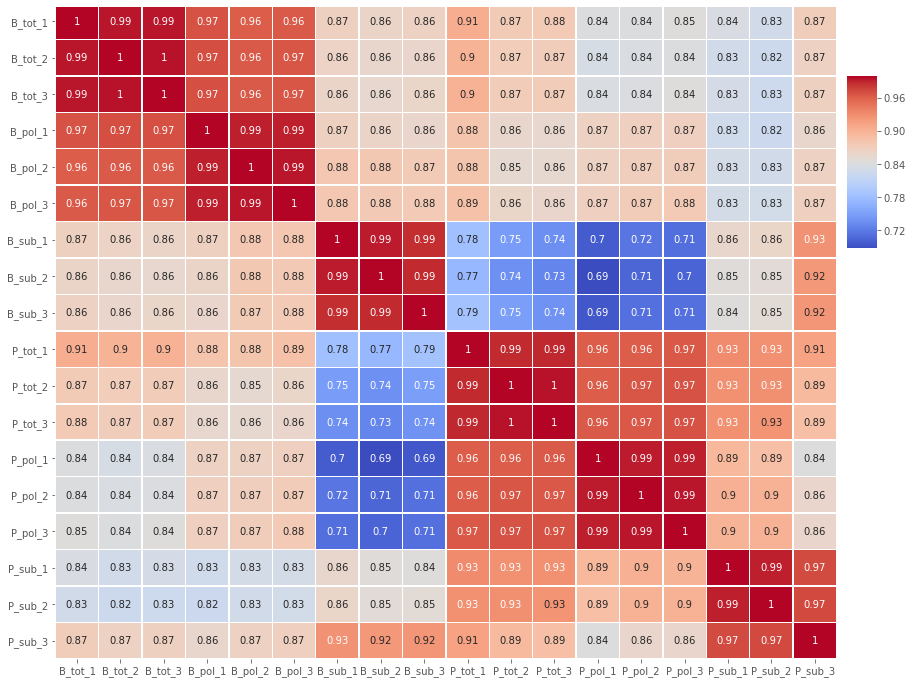

In [11]:
fig,ax=plt.subplots(figsize=(14,12))
cbar_ax = fig.add_axes([.91, .6, .03, .2])
sns.heatmap(np.log2(indata).corr(),
            #vmin=-1,
            cmap='coolwarm',
            annot=True,linewidths=.5,ax=ax, cbar_ax = cbar_ax, cbar=True)
print(ax.get_ylim())
ax.set_ylim(18,0.1)
plt.savefig('Figures/Figure_2.png')
plt.show()

## QC - MSD

{'r': 'BSF', 'b': 'PCF'}


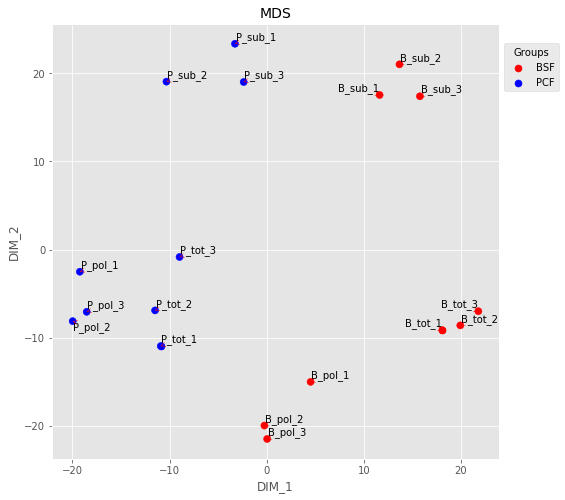

In [12]:
plt.style.use('ggplot')
palette = ['r']*9+['b']*9
fig,ax = plt.subplots(figsize=(8,8), ncols=1, nrows=1)
UT.make_mds(np.log2(indata),palette,ax,color_dictionary={'r':'BSF','b':'PCF'})
plt.savefig('Figures/Figure_3.png')
plt.show()

## Compute Length and GC content

In [13]:
def get_gene_ids(n):
    res = {}
    temp = n.split(';')
    temp =[n.strip() for n in temp if len(n)>2]
    for f in temp:
        key = f.split(' ')[0]
        value = f.split(' ')[1]
        key=key.replace('\"','').replace('\'','').strip()
        value=value.replace('\"','').replace('\'','').strip()
        res[key]=value
    return res['gene_id']

In [14]:
gc_content = pd.read_csv('InData/GC_content_927.txt',sep='\t')
gc_content = gc_content[gc_content['8_usercol']=='transcript']
gc_content['gene_id'] = [get_gene_ids(n) for n in gc_content['10_usercol']]
gc_content = gc_content.drop_duplicates('gene_id')
gc_content.set_index('gene_id',inplace=True)
gc_content=gc_content[['19_seq_len','12_pct_gc']]
gc_content.columns = ['length', 'gccontent']
gc_content.head()

,length,gccontent
gene_id,,
MSTRG.1,2768,0.505419
MSTRG.2,2482,0.304593
TRY.1,746,0.273458
TRY.2,1531,0.288047
TRY.3,1390,0.379856


In [15]:
print(indata.shape)
indata=indata.join(gc_content,how='inner')
gc_content = gc_content[['length', 'gccontent']]
indata.drop(['length', 'gccontent'],axis=1,inplace=True) 
indata.head()

(15743, 18)


,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb10.v4.0073,1,1,0,0,0,0,1,0,2,0,1,2,0,0,0,0,0,0
Tb10.v4.0074,0,1,1,1,0,0,1,2,1,0,0,0,0,0,0,0,0,0
Tb10.v4.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Tb10.v4.0076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0077,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Literature Comparison

In [16]:
scale_rpkm = indata.sum()/1000000
indata_rpkm = indata.divide(scale_rpkm,axis=1)
indata_rpkm=indata_rpkm.join(gc_content,how='left')
indata_rpkm.head()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3,length,gccontent
Tb10.v4.0073,0.026099,0.027861,0.000000,0.000000,0.0,0.0,0.027174,0.000000,0.060649,0.0,0.024299,0.064283,0.0,0.0,0.0,0.000000,0.0,0.00000,561,0.413547
Tb10.v4.0074,0.000000,0.027861,0.029549,0.028106,0.0,0.0,0.027174,0.061636,0.030324,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,678,0.364307
Tb10.v4.0075,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.035462,0.0,0.00000,1443,0.493416
Tb10.v4.0076,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,1458,0.496571
Tb10.v4.0077,0.000000,0.000000,0.000000,0.028106,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.03019,1287,0.471639


In [17]:
length = indata_rpkm['length']
indata_rpkm.drop(['length','gccontent'],inplace=True,axis=1)
indata_rpkm=indata_rpkm.divide(length/1000,axis=0)
indata_rpkm.head()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb10.v4.0073,0.046522,0.049663,0.000000,0.000000,0.0,0.0,0.048438,0.000000,0.108109,0.0,0.043314,0.114587,0.0,0.0,0.0,0.000000,0.0,0.000000
Tb10.v4.0074,0.000000,0.041093,0.043582,0.041454,0.0,0.0,0.040079,0.090909,0.044726,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
Tb10.v4.0075,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.024575,0.0,0.000000
Tb10.v4.0076,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
Tb10.v4.0077,0.000000,0.000000,0.000000,0.021838,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.023458


In [18]:
indata_rpkm['B_tot'] = indata_rpkm[['B_tot_1','B_tot_2','B_tot_3']].median(axis=1)
indata_rpkm['P_tot'] = indata_rpkm[['P_tot_1','P_tot_2','P_tot_3']].median(axis=1)
indata_rpkm['B_sub'] = indata_rpkm[['B_sub_1','B_sub_2','B_sub_3']].median(axis=1)
indata_rpkm['P_sub'] = indata_rpkm[['P_sub_1','P_sub_2','P_sub_3']].median(axis=1)
indata_rpkm['B_pol'] = indata_rpkm[['B_pol_1','B_pol_2','B_pol_3']].median(axis=1)
indata_rpkm['P_pol'] = indata_rpkm[['P_pol_1','P_pol_2','P_pol_3']].median(axis=1)
#indata_rpkm = indata_rpkm[['B_tot','B_sub','B_pol','P_tot','P_sub','P_pol']]

### Load TryTripDB dataset

In [19]:
trypdb =pd.read_csv('InData/RNA_dataset.txt',sep='\t')
trypdb.columns = list(trypdb.columns[0:5])+['PCF1','BSF1','PCF2','BSF2','BSF3','PCF3','BSF4','drop']
trypdb.drop(['drop','Organism'],axis=1,inplace=True)
trypdb.set_index('Gene ID',inplace=True)
trypdb=trypdb.join(indata_rpkm,how='inner')
print(trypdb.shape)
trypdb.head()

(11832, 34)


,source_id,Genomic Location (Gene),Product Description,PCF1,BSF1,PCF2,BSF2,BSF3,PCF3,BSF4,...,P_pol_3,P_sub_1,P_sub_2,P_sub_3,B_tot,P_tot,B_sub,P_sub,B_pol,P_pol
Tb04.24M18.150,Tb04.24M18.150:mRNA,"Tb927_04_v5.1:1,458,621..1,459,109(-)","hypothetical protein, conserved",12.62,9.62,10.98,10.93,16.70,16.56,14.39,...,41.907721,44.962178,38.815111,43.340345,36.679039,53.557511,22.076721,43.340345,20.960390,41.907721
Tb04.3I12.100,Tb04.3I12.100:mRNA,"Tb927_04_v5.1:1,312,814..1,313,406(-)",hypothetical protein,4.36,16.45,1.07,13.91,9.91,1.19,14.99,...,7.913274,17.162941,15.516217,16.342348,42.237876,11.256914,19.739040,16.342348,26.115798,7.655404
Tb05.30F7.410,Tb05.30F7.410:mRNA,"Tb927_05_v5.1:288,984..293,087(-)",hypothetical protein,0.10,0.17,0.02,0.08,0.04,0.01,0.00,...,0.521049,4.000720,3.753728,4.001803,1.666166,1.379564,5.568489,4.000720,1.041990,0.532593
Tb05.5K5.10,Tb05.5K5.10:mRNA,5K5_v5.1:3..97(-),"conserved hypothetical protein, conserved (fra...",12.57,6.04,5.21,6.46,8.62,1.31,9.74,...,1.250519,6.345850,5.811232,5.084643,4.692383,2.342228,6.488036,5.811232,4.200130,1.250519
Tb05.5K5.100,Tb05.5K5.100:mRNA,"5K5_v5.1:17,609..18,248(-)","hypothetical protein, conserved",27.05,19.19,25.31,14.10,25.03,16.22,30.96,...,38.841796,44.715497,47.648640,49.200378,26.506823,29.429632,46.434367,47.648640,27.745611,38.841796


In [20]:
trypdb.iloc[:,3:]=np.log10(trypdb.iloc[:,3:])
trypdb=trypdb.replace(np.inf,np.nan).replace(-np.inf,np.nan).dropna()
print(trypdb.shape)
trypdb.head()

(9686, 34)


,source_id,Genomic Location (Gene),Product Description,PCF1,BSF1,PCF2,BSF2,BSF3,PCF3,BSF4,...,P_pol_3,P_sub_1,P_sub_2,P_sub_3,B_tot,P_tot,B_sub,P_sub,B_pol,P_pol
Tb04.24M18.150,Tb04.24M18.150:mRNA,"Tb927_04_v5.1:1,458,621..1,459,109(-)","hypothetical protein, conserved",1.101059,0.983175,1.040602,1.038620,1.222716,1.219060,1.158061,...,1.622294,1.652847,1.589001,1.636892,1.564418,1.728820,1.343935,1.636892,1.321399,1.622294
Tb04.3I12.100,Tb04.3I12.100:mRNA,"Tb927_04_v5.1:1,312,814..1,313,406(-)",hypothetical protein,0.639486,1.216166,0.029384,1.143327,0.996074,0.075547,1.175802,...,0.898356,1.234592,1.190786,1.213314,1.625702,1.051419,1.295326,1.213314,1.416903,0.883968
Tb05.5K5.100,Tb05.5K5.100:mRNA,"5K5_v5.1:17,609..18,248(-)","hypothetical protein, conserved",1.432167,1.283075,1.403292,1.149219,1.398461,1.210051,1.490801,...,1.589299,1.650458,1.678051,1.691968,1.423358,1.468785,1.666840,1.678051,1.443194,1.589299
Tb05.5K5.110,Tb05.5K5.110:mRNA,"5K5_v5.1:18,623..22,146(-)","major vault protein, putative",1.171726,1.105169,1.246006,1.022428,1.284882,1.077731,1.334253,...,1.405725,1.492125,1.473274,1.434982,1.457868,1.411545,1.333028,1.473274,1.494368,1.394487
Tb05.5K5.120,Tb05.5K5.120:mRNA,"5K5_v5.1:21,693..25,373(-)","hypothetical protein, conserved",0.872739,0.900367,1.106191,0.745075,1.115278,0.972666,1.104828,...,1.130024,1.460340,1.423765,1.390005,1.103305,1.233136,1.232546,1.423765,1.011929,1.110147


In [21]:
import scipy as sp
#test=test.dropna()
def plot_line(x,y,ax,limits=False):
    
    
    linreg = sp.stats.linregress(x, y)
    if limits:
        x = np.array([n for n in x if n > limits[0] and n < limits[1]])
    ax.plot(x, linreg.slope*x + linreg.intercept,alpha=0.5)
    
    ax.text(0.2, 0.8, 'r2='+str(round(linreg.rvalue,2)), 
                               horizontalalignment='center',
               verticalalignment='center',
               transform=ax.transAxes,fontsize=12)

### plots

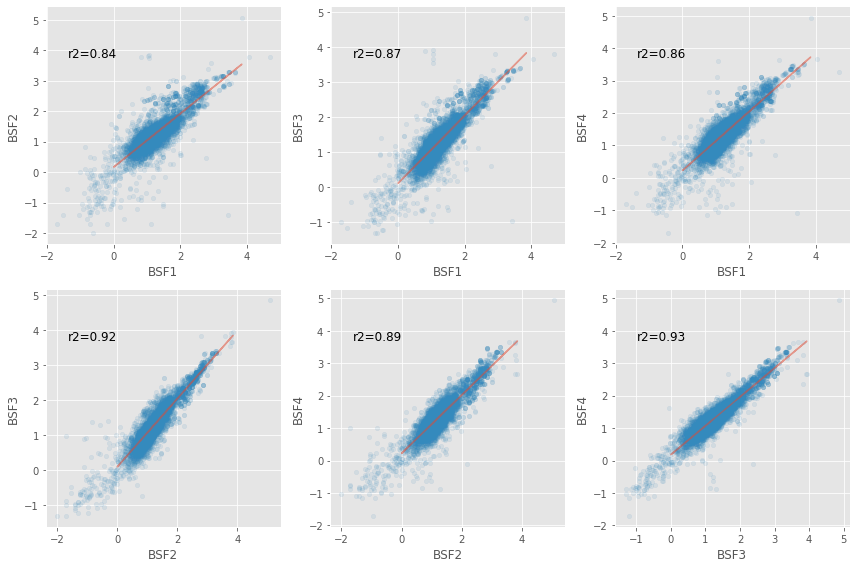

In [22]:
plt.style.use('ggplot')
fig,axes=plt.subplots(ncols=3,nrows=2,figsize=(12,8))
x='BSF1'
y='BSF2'
ax=axes[0,0]
trypdb.plot(kind='scatter',x=x,y=y,alpha=0.1,ax=ax)
plot_line(trypdb[x], trypdb[y], ax, limits=(0,4))

ax=axes[0,1]
x='BSF1'
y='BSF3'
trypdb.plot(kind='scatter',x=x,y=y,alpha=0.1,ax=ax)
plot_line(trypdb[x], trypdb[y], ax, limits=(0,4))

ax=axes[0,2]
x='BSF1'
y='BSF4'
trypdb.plot(kind='scatter',x=x,y=y,alpha=0.1,ax=ax)
plot_line(trypdb[x], trypdb[y], ax, limits=(0,4))

ax=axes[1,0]
x='BSF2'
y='BSF3'
trypdb.plot(kind='scatter',x=x,y=y,alpha=0.1,ax=ax)
plot_line(trypdb[x], trypdb[y], ax, limits=(0,4))

ax=axes[1,1]
x='BSF2'
y='BSF4'
trypdb.plot(kind='scatter',x=x,y=y,alpha=0.1,ax=ax)
plot_line(trypdb[x], trypdb[y], ax, limits=(0,4))

ax=axes[1,2]
x='BSF3'
y='BSF4'
trypdb.plot(kind='scatter',x=x,y=y,alpha=0.1,ax=ax)
plot_line(trypdb[x], trypdb[y], ax, limits=(0,4))
plt.tight_layout()
plt.savefig('Figures/Figure_8.png')

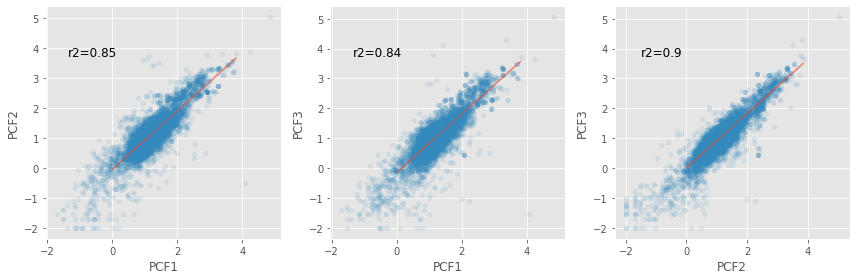

In [23]:
plt.style.use('ggplot')
fig,axes=plt.subplots(ncols=3,nrows=1,figsize=(12,4))

ax=axes[0]
x='PCF1'
y='PCF2'
trypdb.plot(kind='scatter',x=x,y=y,alpha=0.1,ax=ax)
plot_line(trypdb[x], trypdb[y], ax, limits=(0,4))

ax=axes[1]
x='PCF1'
y='PCF3'
trypdb.plot(kind='scatter',x=x,y=y,alpha=0.1,ax=ax)
plot_line(trypdb[x], trypdb[y], ax, limits=(0,4))

ax=axes[2]
x='PCF2'
y='PCF3'
trypdb.plot(kind='scatter',x=x,y=y,alpha=0.1,ax=ax)
plot_line(trypdb[x], trypdb[y], ax, limits=(0,4))
plt.tight_layout()
plt.savefig('Figures/Figure_9.png')

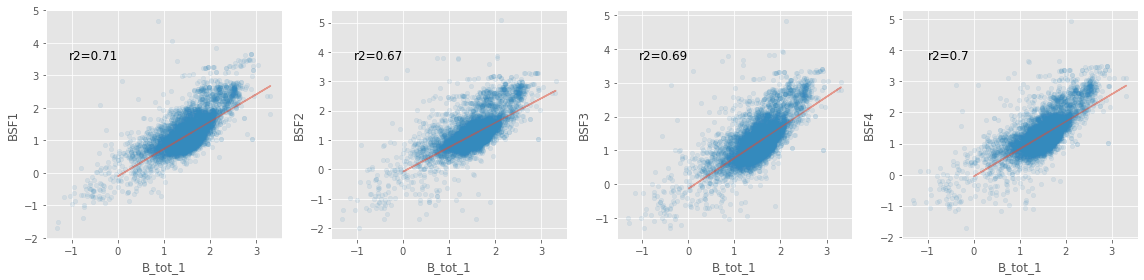

In [24]:

plt.style.use('ggplot')
fig,axes=plt.subplots(ncols=4,nrows=1,figsize=(16,4))

ax=axes[0]
x='B_tot_1'
y='BSF1'
trypdb.plot(kind='scatter',x=x,y=y,alpha=0.1,ax=ax)
plot_line(trypdb[x], trypdb[y], ax, limits=(0,4))

ax=axes[1]
x='B_tot_1'
y='BSF2'
trypdb.plot(kind='scatter',x=x,y=y,alpha=0.1,ax=ax)
plot_line(trypdb[x], trypdb[y], ax, limits=(0,4))

ax=axes[2]
x='B_tot_1'
y='BSF3'
trypdb.plot(kind='scatter',x=x,y=y,alpha=0.1,ax=ax)
plot_line(trypdb[x], trypdb[y], ax, limits=(0,4))


ax=axes[3]
x='B_tot_1'
y='BSF4'
trypdb.plot(kind='scatter',x=x,y=y,alpha=0.1,ax=ax)
plot_line(trypdb[x], trypdb[y], ax, limits=(0,4))


plt.tight_layout()
plt.savefig('Figures/Figure_10.png')

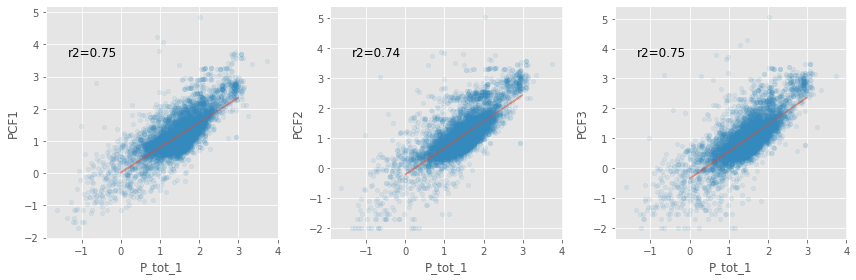

In [25]:
plt.style.use('ggplot')
fig,axes=plt.subplots(ncols=3,nrows=1,figsize=(12,4))

ax=axes[0]
x='P_tot_1'
y='PCF1'
trypdb.plot(kind='scatter',x=x,y=y,alpha=0.1,ax=ax)
plot_line(trypdb[x], trypdb[y], ax, limits=(0,3))


ax=axes[1]
x='P_tot_1'
y='PCF2'
trypdb.plot(kind='scatter',x=x,y=y,alpha=0.1,ax=ax)
plot_line(trypdb[x], trypdb[y], ax, limits=(0,3))


ax=axes[2]
x='P_tot_1'
y='PCF3'
trypdb.plot(kind='scatter',x=x,y=y,alpha=0.1,ax=ax)
plot_line(trypdb[x], trypdb[y], ax, limits=(0,3))
plt.tight_layout()
plt.savefig('Figures/Figure_11.png')

## Data Normalization

### edgeR to filter low counts

In [26]:
%%R -i indata
options(warn=-1)
library("limma") 
library("edgeR")
head(indata)

             B_tot_1 B_tot_2 B_tot_3 B_pol_1 B_pol_2 B_pol_3 B_sub_1 B_sub_2
Tb10.v4.0073       1       1       0       0       0       0       1       0
Tb10.v4.0074       0       1       1       1       0       0       1       2
Tb10.v4.0075       0       0       0       0       0       0       0       0
Tb10.v4.0076       0       0       0       0       0       0       0       0
Tb10.v4.0077       0       0       0       1       0       0       0       0
Tb10.v4.0078       1       0       1       1       0       8       1       5
             B_sub_3 P_tot_1 P_tot_2 P_tot_3 P_pol_1 P_pol_2 P_pol_3 P_sub_1
Tb10.v4.0073       2       0       1       2       0       0       0       0
Tb10.v4.0074       1       0       0       0       0       0       0       0
Tb10.v4.0075       0       0       0       0       0       0       0       1
Tb10.v4.0076       0       0       0       0       0       0       0       0
Tb10.v4.0077       0       0       0       0       0       0       0       0

In [27]:
%%R
group <- factor(c(
    'Btot','Btot','Btot',
    'Bpol','Bpol','Bpol',
    'Bsub','Bsub','Bsub',
    'Ptot','Ptot','Ptot',
    'Ppol','Ppol','Ppol',
    'Psub','Psub','Psub'))

y <- DGEList(counts=indata,group=group)
keep <- filterByExpr(y)
y <- y[keep,,keep.lib.sizes=FALSE]
counts = y$counts
genes = row.names(y)

In [28]:
%R -o counts,genes
indata = pd.DataFrame(counts,index=genes,columns=indata.columns)
indata.shape

(14140, 18)

In [29]:
indata=indata.join(gc_content,how='inner')
indata.shape

(14140, 20)

### GC / length content

In [30]:
gc_content = indata[['length', 'gccontent']]
indata.drop(['length', 'gccontent'],axis=1,inplace=True)
print(indata.shape,gc_content.shape)
indata.head()

(14140, 18) (14140, 2)


,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb927.8.130,7,6,5,1,1,7,12,8,19,5,8,4,3,3,3,11,8,13
Tb927.8.150,47,30,36,19,14,14,26,19,25,26,27,28,10,5,18,17,22,30
Tb927.8.230,7,2,6,2,5,4,18,15,24,1,0,0,0,0,1,0,0,0
Tb927.8.270,1131,954,868,665,625,592,654,675,700,717,494,396,267,249,306,576,639,720
Tb927.8.320,11,12,16,11,14,12,34,48,33,19,22,7,18,20,10,33,65,41


### size factors

In [31]:
sizeFactors=indata.sum()
sizeFactors = sizeFactors.values
sizeFactors

array([38314002, 35890982, 33841087, 35578927, 38349642, 40097783,
       36797906, 32446524, 32974208, 44940986, 41152940, 31111972,
       29976731, 35685354, 33670032, 28198566, 38038321, 33122597])

In [32]:
#np.log2(gc_content['length']/1000).plot(kind='hist')

### Bias Correction

In [33]:
%%R -i gc_content,indata,sizeFactors
library(cqn)
library(scales)

R[write to console]: Loading required package: mclust

R[write to console]: Package 'mclust' version 5.4.6
Type 'citation("mclust")' for citing this R package in publications.

R[write to console]: Loading required package: nor1mix

R[write to console]: Loading required package: preprocessCore

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: quantreg

R[write to console]: Loading required package: SparseM

R[write to console]: 
Attaching package: ‘SparseM’


R[write to console]: The following object is masked from ‘package:base’:

    backsolve




In [34]:
%%R
stopifnot(all(rownames(indata) == rownames(gc_content)))
cqn.subset <- cqn(indata, lengths = gc_content$length,
                  x = gc_content$gccontent, sizeFactors = sizeFactors,
                  verbose = TRUE)

RQ fit ..................
SQN .


In [35]:
%R cqn.subset

R object with classes: ('cqn',) mapped to:
[ListSexpV..., IntSexpVe..., IntSexpVe..., IntSexpVe..., ..., FloatSexp..., FloatSexp..., FloatSexp..., LangSexpV...]
R object with classes: ('cqn',) mapped to:
[ListSexpV..., IntSexpVe..., IntSexpVe..., IntSexpVe..., ..., FloatSexp..., FloatSexp..., FloatSexp..., LangSexpV...]
  lengths: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('RTYPES.INTSXP',) mapped to:
[2,764, 7,764, 1,102, 13,000, ..., 792, 2,195, 816, 530]
  sizeFactors: <class 'rpy2.robjects.vectors.IntArray'>
  R object with classes: ('array',) mapped to:
[38,314,002, 35,890,982, 33,841,087, 35,578,927, ..., 33,670,032, 28,198,566, 38,038,321, 33,122,597]
  subindex: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('RTYPES.INTSXP',) mapped to:
[4, 6, 7, 8, ..., 14,132, 14,133, 14,134, 14,138]
...
  x: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[-8.380822, -8.215943, -8.051065, -7.886186, ..., 7.612393, 7.777272, 7.942150, 8.107029]
  offset: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[0.334512, 0.438454, 0.479700, 0.507985, 0.541282]
  offset0: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[-3.036921, -0.424688, 0.495695, 1.281253, 2.886087]
  glm.offset: <class 'rpy2.rinterface.LangSexpVector'>
  <rpy2.rinterface.LangSexpVector object at 0x2b06edc6c2c8> [RTYPES.LANGSXP]

### Viz Bias

In [36]:
%%R
cqnplot <- function(x, n = 1, col = "grey60", ylab="estimated bias effect", 
                    xlab = "", type = "l", lty = 1, ...) {
    if(class(x) != "cqn")
        stop("'x' needs to be of class 'cqn'")
    if(n == 1) {
        func <- x$func1
        grid <- x$grid1
        knots <- x$knots1
    }
    if(n == 2) {
        if(is.null(x$func2))
            stop("argument 'x' does not appear to have two smooth functions (component 'func2' is NULL)")
        func <- x$func2
        grid <- x$grid2
        knots <- x$knots2
    }
    
    
    #par(mar=c(5.1, 4.1, 4.1, 8.1), xpd=TRUE)
    matplot(replicate(ncol(func), grid), func, ylab = ylab, xlab = xlab, type = type,
            col = col, lty = lty, ...)
    
    legend("bottomleft", legend = colnames(x$counts), inset=c(1,0),
           title="Samples", lty = lty, col = col)
    rug(knots, lwd = 2)
    invisible(x)
    
}


library(repr)
#options(repr.plot.width = 10, repr.plot.height = 0.75)
# Change plot size to 4 x 3
#options(repr.plot.width=4, repr.plot.height=3)


colors <- c(
    'grey','grey','grey',
    'green','green','green',
    'blue','blue','blue',
    'grey','grey','grey',
    'green','green','green',
    'blue','blue','blue'
           )
lty =c(1,1,1,1,1,1,1,1,1,
       2,2,2,2,2,2,2,2,2)

png("Figures/Figure_12.png")
#par(mfrow=c(1,2))
cqnplot(cqn.subset, col=colors,
        n = 1, xlab = "GC content", lty = lty,
        ylim = c(1,12), 
        

       )
dev.off()

#ggsave('plot.png', width=8.27, height= 11.69) #A4 size in inches
#dev.off()

png 
  2 


In [37]:
%%R
library(repr)
#options(repr.plot.width = 12, repr.plot.height = 0.75)
# Change plot size to 4 x 3
#options(repr.plot.width=8, repr.plot.height=3)


colors <- c(
    'grey','grey','grey',
    'green','green','green',
    'blue','blue','blue',
    'grey','grey','grey',
    'green','green','green',
    'blue','blue','blue'
           )
lty =c(1,1,1,1,1,1,1,1,1,
       2,2,2,2,2,2,2,2,2)

#par(mfrow=c(1,2))
png("Figures/Figure_13.png")
cqnplot(cqn.subset, col=colors,
        n = 2, xlab = "length", lty = lty,
        ylim = c(-5,16), 
    
       )
dev.off()

png 
  2 


### Bias Correction

In [38]:
%%R
RPKM.cqn <- cqn.subset$y + cqn.subset$offset
out_table <- RPKM.cqn
head(out_table)

              B_tot_1   B_tot_2   B_tot_3    B_pol_1    B_pol_2   B_pol_3
Tb927.8.130 -3.224160 -3.198538 -3.710261 -3.3992100 -3.1552590 -1.249250
Tb927.8.150 -1.513409 -1.513409 -1.900200 -0.6978133 -1.0689486 -1.153460
Tb927.8.230 -1.068949 -2.725924 -1.068949 -1.3784615 -0.5407033 -1.153460
Tb927.8.270  3.579283  3.406624  3.270790  3.8810715  4.0400187  3.788601
Tb927.8.320 -3.103457 -2.779223 -2.715639 -1.1534597 -0.7665453 -1.153460
Tb927.8.443  5.302482  4.574001  4.967853  1.3965456  0.1144773  1.016399
                B_sub_1     B_sub_2    B_sub_3    P_tot_1    P_tot_2   P_tot_3
Tb927.8.130 -0.64215333 -0.97058229 -0.2939672 -1.0689486 0.83673536 0.5111866
Tb927.8.150  0.06886251 -0.26013019 -0.1967442 -0.1967442 0.92145300 0.9978177
Tb927.8.230  0.11447726 -0.05641687  0.3277041 -0.4609932 0.09150935 0.3952763
Tb927.8.270  4.34190970  4.49779542  4.3379968  3.5792830 3.35929219 3.4191176
Tb927.8.320  0.70342085  1.29301537  0.2883009  0.1364482 1.22688660 0.5829277
Tb927.8.

In [39]:
#out_table

In [40]:
%R -o out_table
out_table = pd.DataFrame(out_table,index=indata.index.values,columns=indata.columns)
out_table.head()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb927.8.130,-3.224160,-3.198538,-3.710261,-3.399210,-3.155259,-1.249250,-0.642153,-0.970582,-0.293967,-1.068949,0.836735,0.511187,0.622622,0.511187,0.635165,0.910768,0.715065,-0.327935
Tb927.8.150,-1.513409,-1.513409,-1.900200,-0.697813,-1.068949,-1.153460,0.068863,-0.260130,-0.196744,-0.196744,0.921453,0.997818,0.478850,-0.293967,0.950223,0.921453,1.062519,0.270191
Tb927.8.230,-1.068949,-2.725924,-1.068949,-1.378462,-0.540703,-1.153460,0.114477,-0.056417,0.327704,-0.460993,0.091509,0.395276,0.691098,0.541795,1.145799,-0.108128,-0.421216,-2.723699
Tb927.8.270,3.579283,3.406624,3.270790,3.881071,4.040019,3.788601,4.341910,4.497795,4.337997,3.579283,3.359292,3.419118,4.045289,3.905356,3.953243,4.494553,4.364820,4.546606
Tb927.8.320,-3.103457,-2.779223,-2.715639,-1.153460,-0.766545,-1.153460,0.703421,1.293015,0.288301,0.136448,1.226887,0.582928,1.908653,1.930661,1.154351,1.836508,2.415772,1.210924


### Visualise Normalized Counts

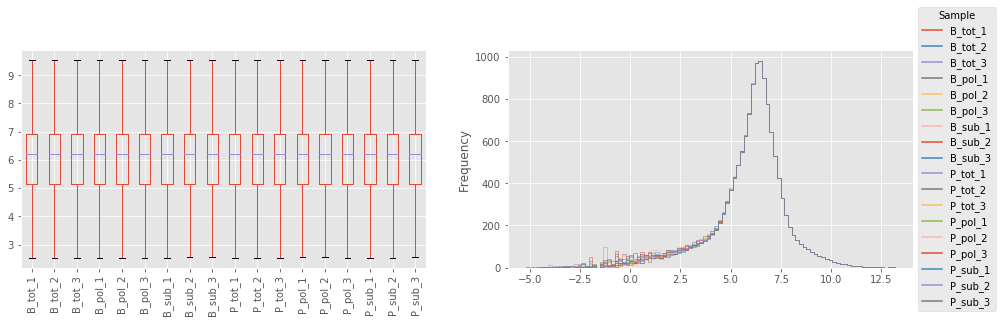

(14140, 18)


In [41]:
fig,axes=plt.subplots(figsize=(16,4),ncols=2)
ax = axes[0]
out_table.plot(kind='box',ax=ax,rot=90,showfliers=False)

ax = axes[1]
out_table.replace(-np.inf,-1.5).plot(kind='hist',
                                            histtype='step',
                                            bins=100,ax=ax)
UT.hist_legend(ax,'Sample')
#ax.set_xticklabels(out_df.columns, rotation=90, )
plt.show()
print(out_table.shape)

## Differential Expression Analysis

In [42]:
%%R
library(edgeR)
# Make groups
design_with_all <- model.matrix( ~0+group )

y <- DGEList(counts=indata, 
                  lib.size = sizeFactors,
                  group = group, 
                  )

y$offset <- cqn.subset$glm.offset
# Estimate dispersion
y <- estimateGLMCommonDisp( y, design_with_all )
y <- estimateGLMTrendedDisp( y, design_with_all )
y <- estimateGLMTagwiseDisp( y, design_with_all )
# Fit counts to model
fit_all <- glmFit( y, design_with_all )
contrast_Bpol_v_Bsub <- glmLRT( fit_all, contrast=makeContrasts( groupBpol-groupBsub,
                                                                levels=design_with_all ) )

table_Bpol_v_Bsub <- topTags(contrast_Bpol_v_Bsub, n=Inf, 
                             sort.by = "none", adjust.method="BH")$table
topTags( contrast_Bpol_v_Bsub, n=5 )
head(table_Bpol_v_Bsub)

                 logFC     logCPM        LR       PValue          FDR
Tb927.8.130 -1.9454605 -1.9979679 11.757856 6.058698e-04 8.725808e-04
Tb927.8.150 -0.8615195 -0.5105419  5.759833 1.639663e-02 2.103315e-02
Tb927.8.230 -1.3652217 -2.4017819  7.245304 7.108669e-03 9.428438e-03
Tb927.8.270 -0.4879796  4.1381651 17.319600 3.159115e-05 4.958913e-05
Tb927.8.320 -1.8885046 -0.4645484 23.793665 1.072348e-06 1.837049e-06
Tb927.8.443 -2.3071488  0.7800660 31.193876 2.335015e-08 4.398762e-08


In [43]:
%%R
contrast_Ppol_v_Psub <- glmLRT( fit_all, contrast=makeContrasts(groupPpol-groupPsub,
                                                                levels=design_with_all ) )

table_Ppol_v_Psub <- topTags(contrast_Ppol_v_Psub, n=Inf, sort.by = "none", adjust.method="BH")$table
topTags( contrast_Ppol_v_Psub, n=5 )

Coefficient:  1*groupPpol -1*groupPsub 
                   logFC   logCPM       LR        PValue           FDR
Tb927.10.1570   3.003779 5.878210 1514.794  0.000000e+00  0.000000e+00
Tb927.11.6565  -3.262284 5.419666 1328.592 6.914518e-291 4.888564e-287
KS17gene_2065a -3.587969 6.575608 1327.315 1.310077e-290 6.174829e-287
KS17gene_6722a -3.370266 6.600012 1250.535 6.351962e-274 2.245419e-270
KS17gene_4624a -2.933946 5.664775 1206.069 2.926871e-264 8.277192e-261


In [44]:
desc_dict

{'Tb10.v4.0078': 'hypothetical protein',
 'Tb927.8.4730': 'amino acid transporter  putative',
 'Tb10.v4.0183': 'variant surface glycoprotein (VSG  pseudogene)  putative',
 'Tb927.8.4470': 'chaperone protein DnaJ  putative',
 'Tb927.7.5460': 'exosome-associated protein 3',
 'Tb927.4.580': 'hypothetical protein  conserved',
 'Tb927.5.2260': 'conserved protein',
 'Tb927.4.740': 'Rgp1  putative',
 'Tb927.9.3540': 'hypothetical protein  conserved',
 'Tb10.NT.68': 'Noncoding RNA  putative',
 'Tb927_10_v4.snoRNA.0022:snoRNA': 'term',
 'Tb927.8.7110': 'Serine/threonine-protein kinase NEK12.1  putative',
 'Tb927.11.5100': 'hypothetical protein  conserved',
 'Tb927.9.12440': 'hypothetical protein  conserved',
 'Tb927.8.7350': 'trans-sialidase  putative',
 'Tb927.11.3770': 'Dpy-30 motif containing protein  putative',
 'Tb927.11.1190': 'Ring finger domain/PHD-finger  putative',
 'Tb927.8.5560': 'NADH dehydrogenase (ubiquinone) 1 beta subcomplex subunit  putative',
 'Tb11.v5.0302': 'hypothetical pr

In [45]:
%R -o table_Ppol_v_Psub
table_Ppol_v_Psub['log_PValue'] = -np.log10(table_Ppol_v_Psub['PValue'])
table_Ppol_v_Psub['log_FDR'] = -np.log10(table_Ppol_v_Psub['FDR'])
table_Ppol_v_Psub['desc']=[desc_dict.get(n,'none') for n in table_Ppol_v_Psub.index.values]
table_Ppol_v_Psub.to_csv('Tables/Table_5.csv')
table_Ppol_v_Psub.head()

,logFC,logCPM,LR,PValue,FDR,log_PValue,log_FDR,desc
Tb927.8.130,-0.078192,-1.997968,0.015379,0.901307,0.915354,0.045127,0.038411,variant surface glycoprotein (VSG atypical) ...
Tb927.8.150,-0.280626,-0.510542,0.518342,0.471550,0.516075,0.326473,0.287287,variant surface glycoprotein degenerate
Tb927.8.230,4.945152,-2.401782,3.214524,0.072987,0.092188,1.136752,1.035327,expression site-associated gene 3 (ESAG3) deg...
Tb927.8.270,-0.504705,4.138165,16.763748,0.000042,0.000073,4.373306,4.133908,variant surface glycoprotein degenerate
Tb927.8.320,-0.231726,-0.464548,0.385014,0.534932,0.577708,0.271702,0.238291,variant surface glycoprotein degenerate


In [46]:
%R -o table_Bpol_v_Bsub
table_Bpol_v_Bsub.head()
table_Bpol_v_Bsub['log_PValue'] = -np.log10(table_Bpol_v_Bsub['PValue'])
table_Bpol_v_Bsub['log_FDR'] = -np.log10(table_Bpol_v_Bsub['FDR'])

In [47]:
table_Bpol_v_Bsub['desc']=[desc_dict.get(n,'none') for n in table_Bpol_v_Bsub.index.values]
table_Bpol_v_Bsub.head()

,logFC,logCPM,LR,PValue,FDR,log_PValue,log_FDR,desc
Tb927.8.130,-1.945460,-1.997968,11.757856,0.000606,0.000873,3.217621,3.059194,variant surface glycoprotein (VSG atypical) ...
Tb927.8.150,-0.861519,-0.510542,5.759833,0.016397,0.021033,1.785245,1.677096,variant surface glycoprotein degenerate
Tb927.8.230,-1.365222,-2.401782,7.245304,0.007109,0.009428,2.148212,2.025560,expression site-associated gene 3 (ESAG3) deg...
Tb927.8.270,-0.487980,4.138165,17.319600,0.000032,0.000050,4.500435,4.304614,variant surface glycoprotein degenerate
Tb927.8.320,-1.888505,-0.464548,23.793665,0.000001,0.000002,5.969664,5.735879,variant surface glycoprotein degenerate


In [48]:
table_Bpol_v_Bsub.to_csv('Tables/Table_4.csv')

In [49]:
#BRP10 Tb927.8.2780
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5568443/
#table_Bpol_v_Bsub.loc['KS17gene_1749a'],table_Ppol_v_Psub.loc['KS17gene_1749a']

In [50]:
#grumpy
#https://www.biorxiv.org/content/10.1101/2020.05.03.074625v1
#table_Bpol_v_Bsub.loc['KS17gene_3137a'],table_Ppol_v_Psub.loc['KS17gene_3137a']

In [51]:
#https://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1006279
#'Tb927.11.14220'
#table_Bpol_v_Bsub.loc['KS17gene_4295a'],table_Ppol_v_Psub.loc['KS17gene_4295a']

In [52]:
#table_Bpol_v_Bsub.shape

### Grumpy

In [53]:
ks_lncRNA = open('GS_gene_list.txt').read().split('\n')
def grampy_VolcanoPlot(table,title,ax=False,ksgene='KS17gene_3137a',xlims=False):
    plt.style.use('ggplot')
    if not ax:
        fig,ax=plt.subplots(figsize=(12,6))
    ax.set_title(title)
    
    table.plot(x='logFC',y='log_FDR',kind='scatter',s=5,alpha=0.2,ax=ax,c='black',label='the rest')
    table.loc[ks_lncRNA].plot(x='logFC',y='log_FDR',kind='scatter',s=10,alpha=1,c='b',ax=ax,
                              label='lncRNA')
    table.loc[[ksgene]].plot(y='log_FDR',x='logFC',kind='scatter',ax=ax,s=50, alpha=1
                                                   ,c='r',label='Grumpy')
    
    lgnd= ax.legend()
    lgnd.legendHandles[0]._sizes = [20]
    lgnd.legendHandles[1]._sizes = [20]
    lgnd.legendHandles[2]._sizes = [20]
    if xlims:
        ax.set_xlim(xlims[0],xlims[1])

def grampy_MAplot(table,title,ksgene='KS17gene_3137a'):
    plt.style.use('ggplot')
    fig,ax=plt.subplots(figsize=(12,6))
    ax.set_title(title)
    table.plot(x='logCPM',y='logFC',kind='scatter',s=5,alpha=0.2,ax=ax,c='black',label='the rest')
    table.loc[ks_lncRNA].plot(x='logCPM',y='logFC',kind='scatter',s=10,alpha=1,c='b',ax=ax,
                             label='lncRNA')
    table.loc[[ksgene]].plot(y='logFC',x='logCPM',kind='scatter',ax=ax,s=50, alpha=1
                                                   ,c='r',label='Grumpy')
    lgnd= ax.legend()
    for i,n in enumerate(lgnd.legendHandles):
        n._sizes = [20]

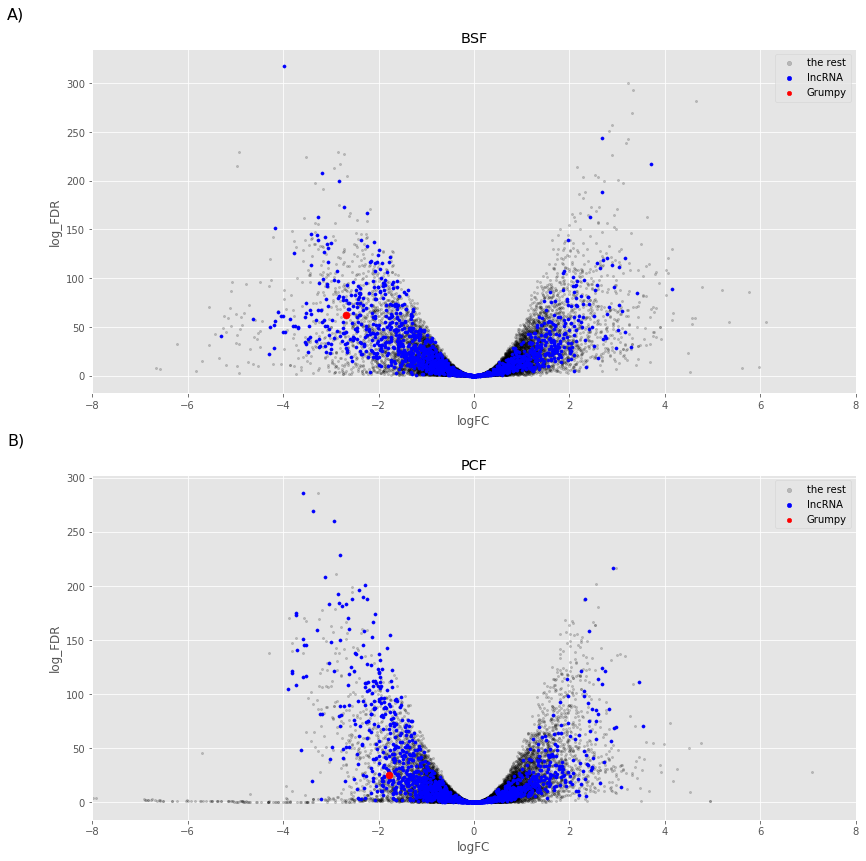

In [54]:
fig,axes=plt.subplots(figsize=(12,12),nrows=2)
grampy_VolcanoPlot(table_Bpol_v_Bsub,'BSF',axes[0],xlims=(-8,8))
grampy_VolcanoPlot(table_Ppol_v_Psub,'PCF',axes[1],xlims=(-8,8))
UT.set_fig_label(axes[0],'A')
UT.set_fig_label(axes[1],'B')
plt.tight_layout()
plt.savefig('Figures/Figure_19.png')

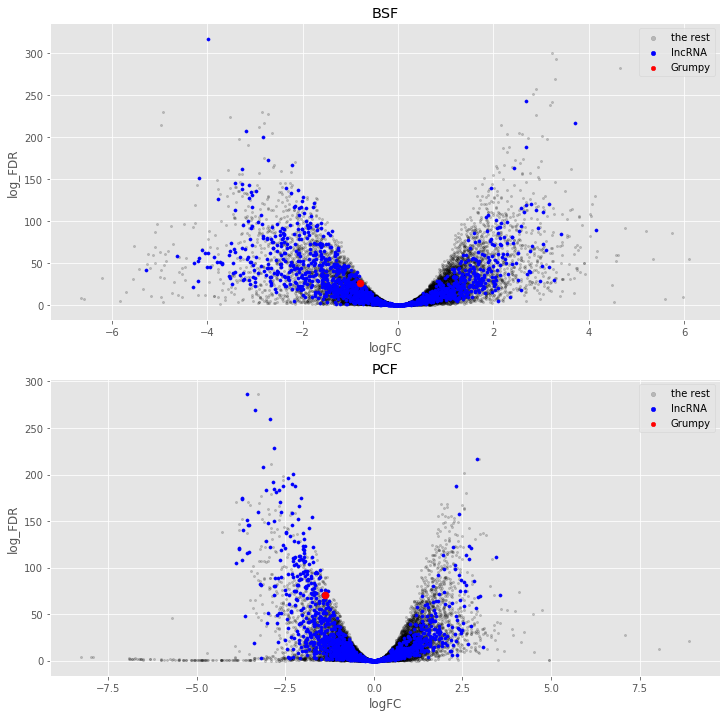

In [55]:
fig,axes=plt.subplots(figsize=(12,12),nrows=2)
grampy_VolcanoPlot(table_Bpol_v_Bsub,'BSF',axes[0],'KS17gene_1749a')
grampy_VolcanoPlot(table_Ppol_v_Psub,'PCF',axes[1],'KS17gene_1749a')


### average subpolysome/polysome

In [56]:
%%R
contrast_pol_v_sub <- glmLRT( fit_all, contrast=makeContrasts((groupPsub+groupBsub)/2-(groupPpol+groupBpol)/2,
                                                                levels=design_with_all ) )

table_pol_v_sub <- topTags(contrast_pol_v_sub, n=Inf, sort.by = "none", adjust.method="BH")$table
topTags( contrast_pol_v_sub, n=20 )
#head(contrast_pol_v_sub)

Coefficient:  -0.5*groupBpol 0.5*groupBsub -0.5*groupPpol 0.5*groupPsub 
                   logFC   logCPM       LR PValue FDR
MSTRG.789      -3.826548 7.003449 1908.266      0   0
KS17gene_34a    3.499395 6.534084 1554.715      0   0
Tb927.8.7860    3.426842 7.572475 1500.735      0   0
KS17gene_2065a  3.211892 6.575608 2244.046      0   0
KS17gene_6398a -3.152002 6.872991 1508.803      0   0
Tb927.10.6060  -3.104437 5.969193 2128.100      0   0
Tb927.4.3870    3.074697 6.483303 1638.481      0   0
Tb927.11.6565   3.032175 5.419666 2323.301      0   0
KS17gene_2098a  2.995356 6.022239 1644.383      0   0
KS17gene_3178a  2.993630 6.000808 1901.049      0   0
Tb927.10.15040  2.973663 6.375815 1541.426      0   0
Tb927.8.6240   -2.831107 7.036564 1914.011      0   0
KS17gene_6722a  2.804813 6.600012 1831.231      0   0
KS17gene_3335a -2.797086 6.354910 1875.888      0   0
Tb927.4.3060   -2.770750 6.080590 1980.702      0   0
TRY.574        -2.718355 5.964096 1635.492      0   0
TRY.222  

In [57]:
%R -o table_pol_v_sub
table_pol_v_sub.head()
table_pol_v_sub['log_PValue'] = -np.log10(table_pol_v_sub['PValue'])
table_pol_v_sub['log_FDR'] = -np.log10(table_pol_v_sub['FDR'])


In [58]:
#table_pol_v_sub.loc['KS17gene_1749a']

#### volcano

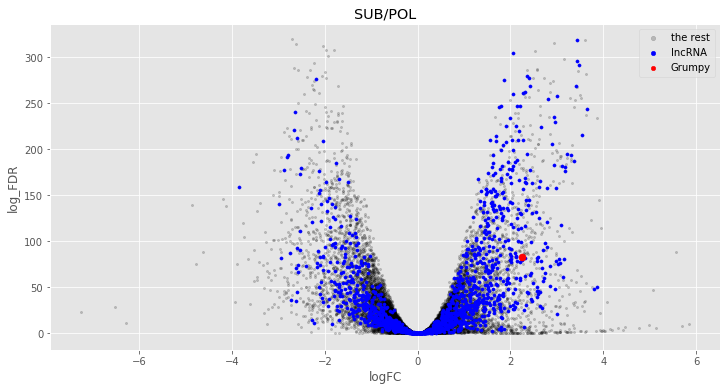

In [59]:
grampy_VolcanoPlot(table_pol_v_sub,'SUB/POL')

#### MA

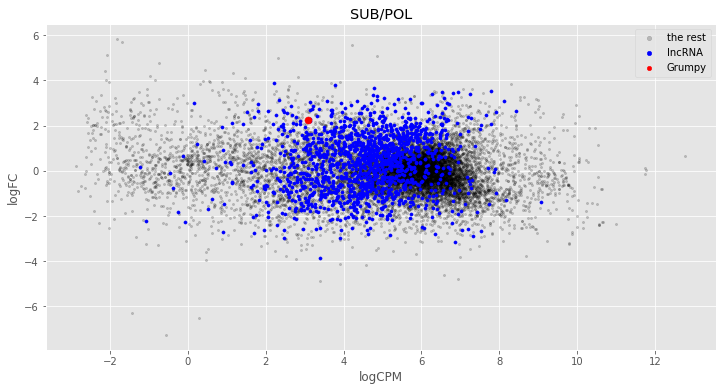

In [60]:
grampy_MAplot(table_pol_v_sub,'SUB/POL')

In [61]:
table_pol_v_sub.loc['KS17gene_4295a']

logFC         0.138912
logCPM        1.380045
LR            0.805346
PValue        0.369500
FDR           0.395993
log_PValue    0.432386
log_FDR       0.402313
Name: KS17gene_4295a, dtype: float64

In [62]:
#table_pol_v_sub.plot(kind='scatter',x='logCPM',y='logFC',alpha=0.1)

## ANOVA Like

In [63]:
%%R
design_anova <- model.matrix(~group, data=y$samples)
fit <- glmQLFit(y, design_anova)
qlf <- glmQLFTest(fit, coef=2:6)
anova_like <- topTags(qlf, n=Inf, sort.by = "none", adjust.method="BH")$table
head(anova_like)

            logFC.groupBsub logFC.groupBtot logFC.groupPpol logFC.groupPsub
Tb927.8.130       1.9488932      -0.8644124       2.8128969       2.8725738
Tb927.8.150       0.8615262      -0.6227824       1.4198728       1.6966349
Tb927.8.230       1.3650291      -0.4068641       0.1740327      -4.7707836
Tb927.8.270       0.4878717      -0.4807085       0.0594783       0.5641392
Tb927.8.320       1.8839223      -1.8004422       2.7445992       2.9687509
Tb927.8.443       2.3096691       4.2848859       1.0487079       2.5722518
            logFC.groupPtot     logCPM         F       PValue          FDR
Tb927.8.130       2.4387274 -1.9979679 14.751498 1.582484e-05 1.792400e-05
Tb927.8.150       1.5769413 -0.5105419 16.176479 8.733023e-06 1.003616e-05
Tb927.8.230      -0.7973363 -2.4017819  7.232887 1.500810e-03 1.566390e-03
Tb927.8.270      -0.4495141  4.1381651 42.859030 9.404012e-09 1.451350e-08
Tb927.8.320       1.6962779 -0.4645484 42.508045 9.994488e-09 1.535775e-08
Tb927.8.443       

In [64]:
%R -o anova_like
anova_like=anova_like[['F', 'PValue', 'FDR']]
anova_threshold = 1e-2
anova_like.shape,anova_like[anova_like['FDR']<anova_threshold].shape

((14140, 3), (13788, 3))

In [65]:
out_table.shape

(14140, 18)

In [66]:
#%%R
#library(HybridMTest)
#computed but not used for now
#anova_test <- row.oneway.anova(cpm_df, group)
#FDR1 <- p.adjust(anova_test$pval, "bonferroni")

In [67]:
#%R -o cpm_df,anova_test,FDR1,tt_Bsub_Bpol

In [68]:
#%R length(FDR1[FDR1 < 0.01])

In [69]:
out_df = out_table.copy()

In [70]:
out_df.head()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb927.8.130,-3.224160,-3.198538,-3.710261,-3.399210,-3.155259,-1.249250,-0.642153,-0.970582,-0.293967,-1.068949,0.836735,0.511187,0.622622,0.511187,0.635165,0.910768,0.715065,-0.327935
Tb927.8.150,-1.513409,-1.513409,-1.900200,-0.697813,-1.068949,-1.153460,0.068863,-0.260130,-0.196744,-0.196744,0.921453,0.997818,0.478850,-0.293967,0.950223,0.921453,1.062519,0.270191
Tb927.8.230,-1.068949,-2.725924,-1.068949,-1.378462,-0.540703,-1.153460,0.114477,-0.056417,0.327704,-0.460993,0.091509,0.395276,0.691098,0.541795,1.145799,-0.108128,-0.421216,-2.723699
Tb927.8.270,3.579283,3.406624,3.270790,3.881071,4.040019,3.788601,4.341910,4.497795,4.337997,3.579283,3.359292,3.419118,4.045289,3.905356,3.953243,4.494553,4.364820,4.546606
Tb927.8.320,-3.103457,-2.779223,-2.715639,-1.153460,-0.766545,-1.153460,0.703421,1.293015,0.288301,0.136448,1.226887,0.582928,1.908653,1.930661,1.154351,1.836508,2.415772,1.210924


## RadViz - Signature in BSF SUB

In [71]:
#https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

#from cqn These values are on the log2scale.        
radviz_dataset = np.exp(out_df).copy()

radviz_dataset=radviz_dataset[anova_like['FDR']<anova_threshold]
cols = list(radviz_dataset.columns)
#group coluns in cunk of 3 to compute the mean
col_grups = chunks(cols, 3)
for g in col_grups:
    base = '_'.join(g[0].split('_')[0:2])
    radviz_dataset[base]=radviz_dataset[g].median(axis=1)

#assign each gene to the class with max count

classes = radviz_dataset.iloc[:,18:].idxmax(axis=1)
#replace = {'B_pol':0, 'B_sub':1, 'B_tot':2, 'P_pol':3, 'P_sub':4, 'P_tot':5}
#classes = classes.replace(replace)
radviz_dataset=radviz_dataset.iloc[:,18:]
radviz_dataset['classes']=classes
radviz_dataset.head()

,B_tot,B_pol,B_sub,P_tot,P_pol,P_sub,classes
Tb927.8.130,0.039789,0.042627,0.526158,1.667268,1.863808,2.044319,P_sub
Tb927.8.150,0.220158,0.343369,0.821401,2.512939,1.614216,2.512939,P_tot
Tb927.8.230,0.343369,0.315543,1.121287,1.095827,1.995906,0.656248,P_pol
Tb927.8.270,30.163248,48.476128,76.854167,30.542452,52.104042,89.528121,P_sub
Tb927.8.320,0.062087,0.315543,2.020653,1.791275,6.743998,6.274590,P_pol


In [72]:
radviz_dataset.shape

(13788, 7)

### RadViz figure

P_sub
B_tot
B_pol
B_sub
P_tot
P_pol
['B_tot', 'P_tot', 'B_sub', 'P_sub', 'B_pol', 'P_pol']


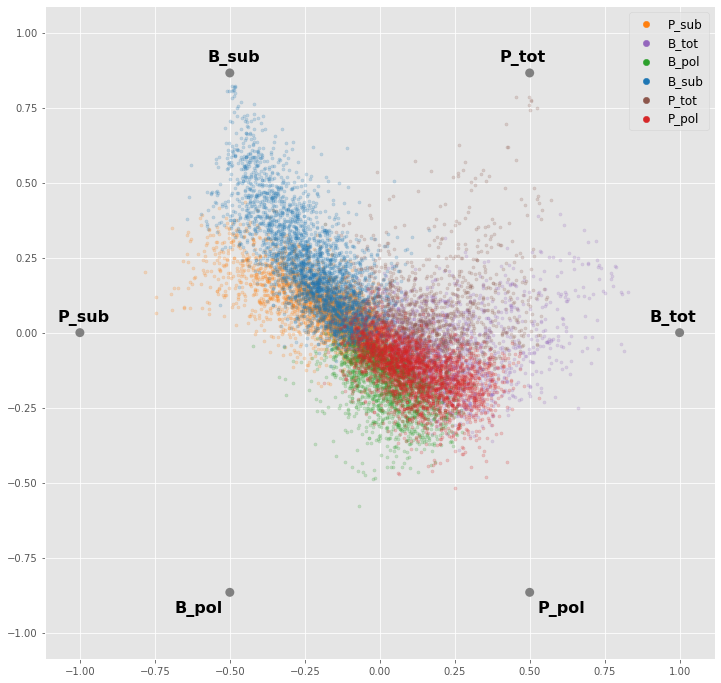

In [73]:
fig,ax=plt.subplots(figsize=(12,12))
cols = [n for n in out_df.columns if n.endswith('_mean')]
color = {'B_tot':'tab:purple','B_pol':'tab:green','B_sub':'tab:blue',
         'P_tot':'tab:brown','P_pol':'tab:red','P_sub':'tab:orange'}

radviz_dataset=radviz_dataset[['B_tot','P_tot','B_sub','P_sub','B_pol','P_pol','classes']]
rad_viz,to_plot,s = UT.radviz(radviz_dataset, 
                           'classes', color=color,ax=ax,)
plt.savefig('Figures/Figure_14.png')

## Cluster analysis

In [74]:
#mydata = out_df.iloc[:,:18]
#min_values = []
#for col in mydata:
#    min_values.append(mydata[col][mydata[col]>0].min())
#min_values
#del mydata


cluster_dataset=np.exp(out_df.iloc[:,:18])#+min_values
cluster_dataset.head()
cluster_dataset.describe()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
count,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000,14140.000000
mean,1682.889865,1682.810315,1682.868204,1682.960943,1682.964738,1682.937061,1683.215612,1683.320872,1683.354262,1683.136643,1683.332431,1683.326044,1683.550484,1683.526133,1683.454720,1683.283210,1683.298666,1683.177386
std,9275.996988,9276.010759,9276.000763,9275.984349,9275.983525,9275.988569,9275.940797,9275.923253,9275.917762,9275.953847,9275.919088,9275.920623,9275.882495,9275.886348,9275.897889,9275.928881,9275.926377,9275.948707
min,0.006446,0.012079,0.005580,0.012529,0.013347,0.022121,0.030553,0.015676,0.008765,0.016858,0.081887,0.095424,0.091765,0.058042,0.094377,0.083746,0.060956,0.010987
25%,173.272025,173.272025,173.272025,173.425773,173.272025,173.272025,173.741577,174.051689,174.051689,173.741577,173.823840,173.823840,174.134962,174.134962,173.823840,173.741577,173.741577,174.134962
50%,490.535927,490.535927,490.535927,490.535927,490.535927,490.535927,490.535927,490.535927,490.635428,490.535927,490.535927,490.535927,490.635428,490.635428,490.535927,490.535927,490.635428,490.535927
75%,998.094838,998.094838,998.094838,998.094838,998.094838,998.094838,998.094838,998.094838,998.094838,998.094838,998.094838,998.094838,998.094838,998.094838,998.094838,998.094838,998.094838,998.094838
max,531186.340614,531186.340614,531186.340614,531186.340614,531186.340614,531186.340614,531186.340614,531186.340614,531186.340614,531186.340614,531186.340614,531186.340614,531186.340614,531186.340614,531186.340614,531186.340614,531186.340614,531186.340614


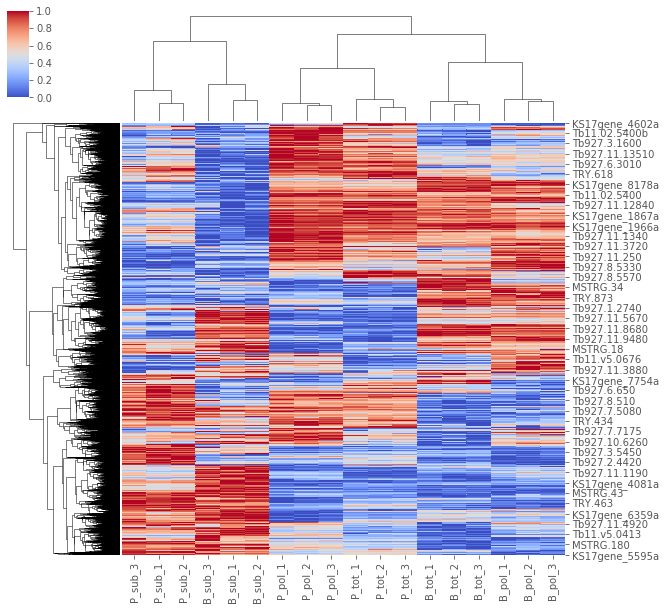

In [75]:
#%R -o anova_test,FDR
cluster_dataset=out_df.iloc[:,:18]
clustergrid = sns.clustermap(cluster_dataset[anova_like['FDR']<anova_threshold],
                             cmap=sns.color_palette("coolwarm", 256), 
                             standard_scale=0)


### Number of clusters

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


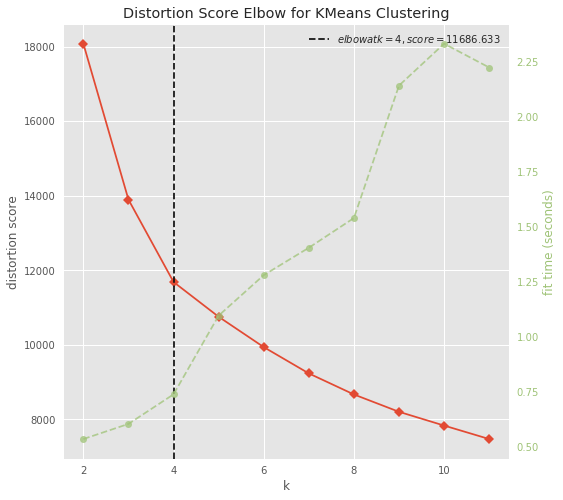

In [76]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
plt.style.use('ggplot')
X = UT.standard_scale(cluster_dataset[anova_like['FDR']<anova_threshold],0)
# Instantiate the clustering model and visualizer
model = KMeans()
fig, ax = plt.subplots(figsize=(8,8)) 
visualizer = KElbowVisualizer(model, k=(2,12),ax=ax)

visualizer.fit(X.values)        # Fit the data to the visualizer


visualizer.show(outpath="Figures/Figure_15.png")
#visualizer.show()


In [77]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
pd.Series(kmeans.labels_).value_counts()

1    4330
2    3508
0    3184
3    2766
dtype: int64

In [78]:
#from sklearn.cluster import SpectralBiclustering

#clustering = SpectralBiclustering(n_clusters=5,
#assign_labels="discretize",
#random_state=0).fit(X)
#pd.Series(clustering.labels_).value_counts()

### Cluster figure

In [79]:
#print(order)
#dict_replace = dict(zip(order,[1,2,3,4]))

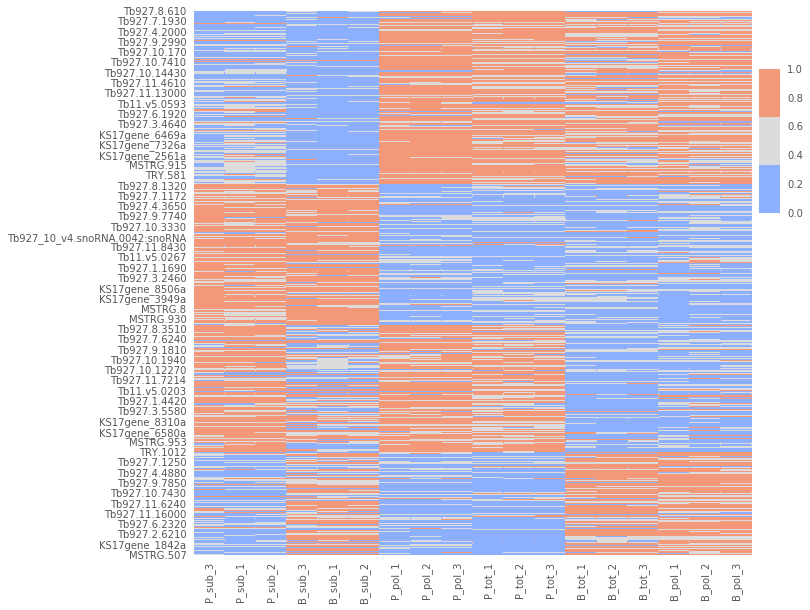

In [80]:
#res = TDdf[anova_test['FDR']<0.01]
X['label']=kmeans.labels_+1
#X['label']=X['label'].replace(dict_replace)
order = pd.Series(kmeans.labels_).value_counts().index.values

list_df = []
for n in order:
    list_df.append(X[X['label']==n+1])

final_list_df = []
for index,temp_df in enumerate(list_df):
    temp_df['label']=index+1
    final_list_df.append(temp_df)
    

X = pd.concat(final_list_df)


fig, ax = plt.subplots(figsize=(10,10))  
cbar_ax = fig.add_axes([.91, .6, .03, .2])
# Sample figsize in inches




sns.heatmap(X.iloc[:,0:-1].T.iloc[
    clustergrid.dendrogram_col.reordered_ind].T.astype(float),
            cmap=sns.color_palette("coolwarm", 3),
           ax=ax, cbar_ax = cbar_ax, cbar=True)

plt.savefig('Figures/Figure_16.png')

In [81]:
X.sort_values(['label']).drop_duplicates('label')['label']

Tb927.8.610     1
Tb927.3.2920    2
Tb927.3.4370    3
Tb927.3.1085    4
Name: label, dtype: int64

In [82]:
clusters = list(X['label'].unique())
X.groupby('label').size()

label
1    4330
2    3508
3    3184
4    2766
dtype: int64

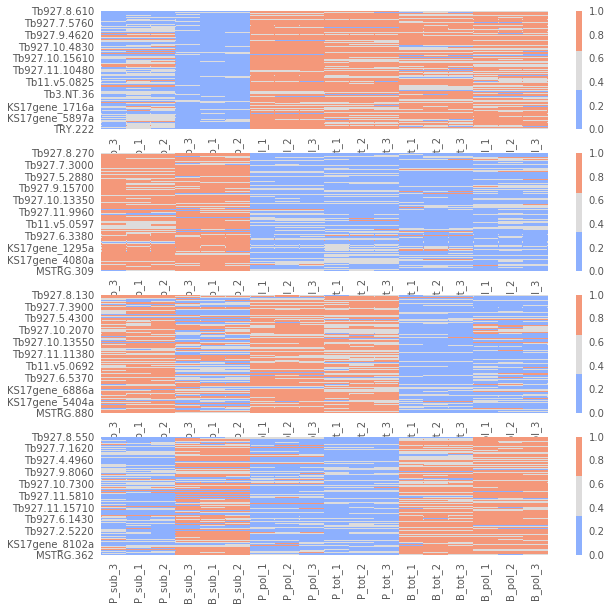

In [83]:
fig, axes = plt.subplots(figsize=(10,10),nrows=4)

for c in [1,2,3,4]:
    
    #print(c,c-1)
    b=c-1
    sns.heatmap(X[X['label']==c].iloc[:,0:-1].T.iloc[
    clustergrid.dendrogram_col.reordered_ind].T.astype(float),
    cmap=sns.color_palette("coolwarm", 3),
    ax=axes[b])



In [84]:
ks_lncRNA = open('GS_gene_list.txt').read().split('\n')
X['is_ks']=[1 if n in ks_lncRNA else 0 for n in X.index.values]
len(ks_lncRNA)
X['is_ks'].value_counts()

0    12377
1     1411
Name: is_ks, dtype: int64

### Table lncRNA enrichment in clusters 


In [85]:
from scipy import stats


#k = np.arange(5)
#N = 52 # population size
#G = 4  # number of good elements in population
#n = 5  # simple random sample size
#stats.hypergeom.pmf(k, N, G, n)

population_size = X.shape[0]

for n in [1,2,3,4]:
    sample_size = X[X['label']==n].shape[0]
    sample_sucess = X[(X['label']==n) & (X['is_ks']==1) ].shape[0]
    population_sucess = X[X['is_ks']==1].shape[0]
    #print(n, sample_sucess, sample_size, population_sucess, population_size)
    print('cluster {n}: enrichment pvalue={pval:.2e}'.format(n=n, pval =stats.hypergeom.pmf(sample_sucess, 
                                 population_size, 
                                 population_sucess, 
                                 sample_size)))
        
    #avg_value = cluster_dataset.loc[X[(X['label']==n)].index.values][
    #    ['BSF-PCF-1','BSF-PCF-2','BSF-PCF-3']].median(axis=1).median()
    #print(np.log2(avg_value))
    print('_________')

cluster 1: enrichment pvalue=2.19e-03
_________
cluster 2: enrichment pvalue=7.19e-14
_________
cluster 3: enrichment pvalue=2.66e-02
_________
cluster 4: enrichment pvalue=2.12e-09
_________


### Cluster Table

In [86]:

X['desc']=[desc_dict.get(n,'none') for n in X.index.values]
X['H/ACA-like snoRNA']=[1 if 'H/ACA-like snoRNA' in n else 0 for n in X['desc']]
X['snoRNA']=[1 if 'snoRNA' in n else 0 for n in X.index.values]
X['Noncoding']=[1 if 'Noncoding RNA' in n else 0 for n in X['desc']]

### Table snoRNA

In [87]:
X.groupby('label')['snoRNA','H/ACA-like snoRNA','is_ks'].sum()

,snoRNA,H/ACA-like snoRNA,is_ks
label,,,
1,21,5,407
2,174,44,475
3,52,11,325
4,23,6,204


In [88]:
X.to_csv('Tables/Table_1.csv')

In [89]:
for n in [1,2,3,4]:
    sample_size = X[X['label']==n].shape[0]
    sample_sucess = X[(X['label']==n) & (X['H/ACA-like snoRNA']==1) ].shape[0]
    population_sucess = X[X['H/ACA-like snoRNA']==1].shape[0]
    #print(n, sample_sucess, sample_size, population_sucess, population_size)
    print('cluster {n}: enrichment pvalue={pval:.2e}'.format(n=n, pval =stats.hypergeom.pmf(sample_sucess, 
                                 population_size, 
                                 population_sucess, 
                                 sample_size)))
        
    #avg_value = cluster_dataset.loc[X[(X['label']==n)].index.values][
    #    ['BSF-PCF-1','BSF-PCF-2','BSF-PCF-3']].median(axis=1).median()
    #print(np.log2(avg_value))
    print('_________')

cluster 1: enrichment pvalue=2.71e-06
_________
cluster 2: enrichment pvalue=1.74e-12
_________
cluster 3: enrichment pvalue=5.71e-02
_________
cluster 4: enrichment pvalue=8.58e-03
_________


In [90]:
for n in [1,2,3,4]:
    sample_size = X[X['label']==n].shape[0]
    sample_sucess = X[(X['label']==n) & (X['snoRNA']==1) ].shape[0]
    population_sucess = X[X['snoRNA']==1].shape[0]
    #print(n, sample_sucess, sample_size, population_sucess, population_size)
    print('cluster {n}: enrichment pvalue={pval:.2e}'.format(n=n, pval =stats.hypergeom.pmf(sample_sucess, 
                                 population_size, 
                                 population_sucess, 
                                 sample_size)))
        
    #avg_value = cluster_dataset.loc[X[(X['label']==n)].index.values][
    #    ['BSF-PCF-1','BSF-PCF-2','BSF-PCF-3']].median(axis=1).median()
    #print(np.log2(avg_value))
    print('_________')

cluster 1: enrichment pvalue=2.39e-21
_________
cluster 2: enrichment pvalue=2.56e-42
_________
cluster 3: enrichment pvalue=1.89e-02
_________
cluster 4: enrichment pvalue=8.53e-08
_________


In [91]:
for n in [1,2,3,4]:
    sample_size = X[X['label']==n].shape[0]
    sample_sucess = X[(X['label']==n) & (X['Noncoding']==1) ].shape[0]
    population_sucess = X[X['Noncoding']==1].shape[0]
    #print(n, sample_sucess, sample_size, population_sucess, population_size)
    print('cluster {n}: enrichment pvalue={pval:.2e}'.format(n=n, pval =stats.hypergeom.pmf(sample_sucess, 
                                 population_size, 
                                 population_sucess, 
                                 sample_size)))
        
    #avg_value = cluster_dataset.loc[X[(X['label']==n)].index.values][
    #    ['BSF-PCF-1','BSF-PCF-2','BSF-PCF-3']].median(axis=1).median()
    #print(np.log2(avg_value))
    print('_________')

cluster 1: enrichment pvalue=3.57e-06
_________
cluster 2: enrichment pvalue=1.77e-03
_________
cluster 3: enrichment pvalue=6.80e-07
_________
cluster 4: enrichment pvalue=1.35e-05
_________


## GO term Analysis

In [92]:
from goatools.base import download_go_basic_obo
from goatools.associations import read_associations
from goatools.go_enrichment import GOEnrichmentStudy
from goatools.obo_parser import GODag
from goatools.associations import read_gaf

### Fix gaf file

In [93]:
import tqdm
replace_dict = {'P':'BP','F':'MF','C':'CC'}
def pars_trytripDB_gaf(infile):
    new_file = open(infile.replace('.gaf','2.gaf'),'w')
    for l in tqdm.tqdm(open(infile)):
        if l.startswith('!'):
            #new_file.write(l)
            continue
        else:    
            temp_list = l.split('\t')
            code = l.split('\t')[8]
            if code not in  replace_dict:
                continue
            temp_list[8] = replace_dict[code]
            new_file.write(temp_list[1]+'\t'+temp_list[4]+'\n')
    new_file.close()

pars_trytripDB_gaf('InData/TriTrypDB-46_TbruceiTREU927_GO.gaf')    

36000it [00:00, 363336.32it/s]


In [94]:
obo_fname = download_go_basic_obo()
in_go=os.path.join('InData/go-basic.obo')
obodag = GODag(in_go)
geneid2gos = read_associations('InData/TriTrypDB-46_TbruceiTREU927_GO2.gaf')

  EXISTS: go-basic.obo
InData/go-basic.obo: fmt(1.2) rel(2020-06-01) 47,233 GO Terms
HMS:0:00:00.078780  26,294 annotations READ: InData/TriTrypDB-46_TbruceiTREU927_GO2.gaf 
**ERROR IdToGosReader(..., godag=None).get_id2gos: GODAG is None. IGNORING namespace(BP)

7683 IDs in all associations

In [95]:
out_df.shape,X.shape

((14140, 18), (13788, 24))

In [96]:
all_genes = out_df.index.values
print(len(all_genes))
goeaobj = GOEnrichmentStudy(
            list(all_genes), # List of mouse protein-coding genes
            geneid2gos, # geneid/GO associations
            obodag, # Ontologies
            propagate_counts = False,
            alpha = 0.05, # default significance cut-off
            methods = ['fdr_bh'])

14140

Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 52%  7,363 of 14,140 population items found in association


In [97]:
all_res = []
def analysis(data, cluster_id=0):
    geneids_study =  list(data[(data['label']==cluster_id)].index.values)
    geneids_study = [n for n in geneids_study if n in all_genes]
    goea_results_all = goeaobj.run_study(geneids_study)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.01]
    for item in goea_results_sig:
        item_list = str(item).split('\t')
        #print(item_list)
        tempres = [str(cluster_id), item_list[0], str(item_list[6]), item_list[1], item_list[3], item_list[4]]
        all_res.append('\t'.join(tempres))

for n in [1,2,3,4]:
    print(n,'_________________')
    analysis(X, cluster_id=n)

print(len(all_res))    
go_term_res = open('InData/goterm_enrich.txt','w')
go_term_res.write('\n'.join(all_res))
go_term_res.close()

1 _________________

Run GOEA Gene Ontology Analysis: current study set of 4330 IDs ... 57%  2,487 of  4,330 study items found in association
100%  4,330 of  4,330 study items found in population(14140)
Calculating 1,948 uncorrected p-values using fisher_scipy_stats
   1,948 GO terms are associated with  7,363 of 14,140 population items
   1,245 GO terms are associated with  2,487 of  4,330 study items
  METHOD fdr_bh:
      67 GO terms found significant (< 0.05=alpha) ( 55 enriched +  12 purified): statsmodels fdr_bh
   2,073 study items associated with significant GO IDs (enriched)
     127 study items associated with significant GO IDs (purified)
2 _________________

Run GOEA Gene Ontology Analysis: current study set of 3508 IDs ... 47%  1,666 of  3,508 study items found in association
100%  3,508 of  3,508 study items found in population(14140)
Calculating 1,948 uncorrected p-values using fisher_scipy_stats
   1,948 GO terms are associated with  7,363 of 14,140 population items
   

In [98]:
#pd.read_csv??

In [99]:
go_terms = pd.read_csv('InData/goterm_enrich.txt', sep='\t', header=None)
go_terms.columns = ['clusterID','goID','pvalue','goType','goDesc','found']
go_terms['found']=[int(n.split('/')[0]) for n in go_terms['found']]
go_terms['clusterID'] = ['C'+str(n) for n in go_terms['clusterID']]
print(go_terms.shape)
go_terms = go_terms[go_terms['found']>=2]
print(go_terms.shape)
del go_terms['found']
go_terms.head()

(66, 6)
(65, 6)


,clusterID,goID,pvalue,goType,goDesc
0,C1,GO:0010608,2.180000e-09,BP,posttranscriptional regulation of gene expression
1,C1,GO:0051603,2.370000e-09,BP,proteolysis involved in cellular protein catab...
2,C1,GO:0006950,6.280000e-08,BP,response to stress
3,C1,GO:0007018,9.620000e-07,BP,microtubule-based movement
4,C1,GO:0006511,1.540000e-05,BP,ubiquitin-dependent protein catabolic process


In [100]:
go_terms['clusterID'].value_counts()

C1    46
C4     9
C3     5
C2     5
Name: clusterID, dtype: int64

In [101]:
unique_go = go_terms.goID.value_counts()[go_terms.goID.value_counts()<=3].index.values
go_terms = go_terms[go_terms.goID.isin(unique_go)]
go_terms.head()

,clusterID,goID,pvalue,goType,goDesc
0,C1,GO:0010608,2.180000e-09,BP,posttranscriptional regulation of gene expression
1,C1,GO:0051603,2.370000e-09,BP,proteolysis involved in cellular protein catab...
2,C1,GO:0006950,6.280000e-08,BP,response to stress
3,C1,GO:0007018,9.620000e-07,BP,microtubule-based movement
4,C1,GO:0006511,1.540000e-05,BP,ubiquitin-dependent protein catabolic process


In [102]:
go_terms['clusterID'].value_counts()

C1    46
C4     9
C3     5
C2     5
Name: clusterID, dtype: int64

In [103]:
go_terms = go_terms[go_terms['clusterID']!='C1']

In [104]:
#vizGo = pd.pivot_table(go_terms, index='goID',columns['clusterID'])#.reset_index()
vizGo = pd.pivot_table(go_terms, index='goDesc', columns=['clusterID'])
vizGo = -np.log10(vizGo)
vizGo=vizGo.fillna(0)
print(vizGo.head())
vizGo.columns = ['C2','C3','C4']
vizGo =vizGo.sort_values(['C2','C3','C4'])
vizGo.head()

                                             pvalue               
clusterID                                        C2   C3        C4
goDesc                                                            
ATP binding                                5.182435  0.0  0.000000
BBSome                                     4.560667  0.0  0.000000
S-adenosylmethionine biosynthetic process  0.000000  0.0  6.381952
antigenic variation                        0.000000  0.0  6.721246
cell surface                               0.000000  0.0  6.493495


,C2,C3,C4
goDesc,,,
S-adenosylmethionine biosynthetic process,0.0,0.0,6.381952
methionine adenosyltransferase activity,0.0,0.0,6.381952
cell surface,0.0,0.0,6.493495
antigenic variation,0.0,0.0,6.721246
integral component of membrane,0.0,0.0,11.625252


In [105]:
vizGo.tail()

,C2,C3,C4
goDesc,,,
BBSome,4.560667,0.0,0.0
ciliary plasm,4.694649,0.0,0.0
ATP binding,5.182435,0.0,0.0
cytoplasm,5.498941,0.0,0.0
mRNA binding,12.134896,0.0,0.0


### GO term Figure

(14.5, 0.5)


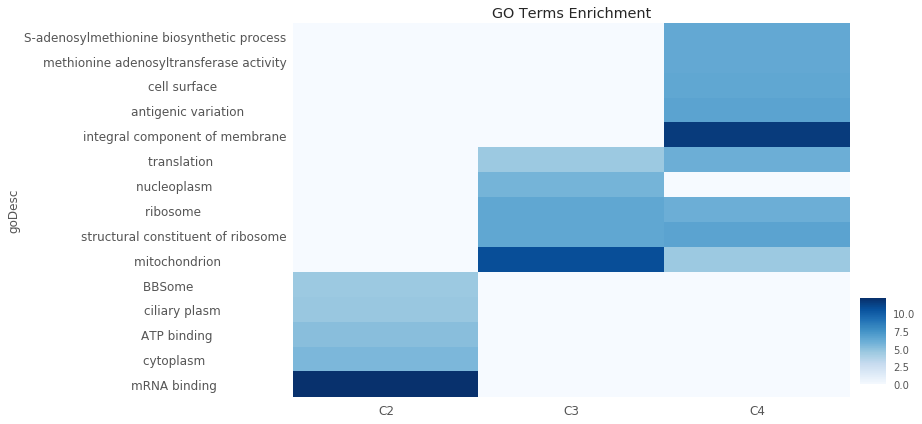

In [106]:
#del vizGo['C1']
fig, ax = plt.subplots(figsize=(12,6))  
cbar_ax = fig.add_axes([1, .1, .03, .2])
# Sample figsize in inches
sns.heatmap(vizGo,
            cmap=sns.color_palette("Blues", 128),
           ax=ax, cbar_ax = cbar_ax, cbar=True)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('GO Terms Enrichment')
print(ax.get_ylim())
ax.set_ylim(ax.get_ylim()[0]+0.5, 0)
plt.tight_layout()
plt.savefig('Figures/Figure_17.png')
plt.show()

### GO enrichment

In [107]:
np.log10(0.01)

-2.0

In [108]:
Bsub_genes = table_Bpol_v_Bsub[ (table_Bpol_v_Bsub['log_FDR']>2) & (table_Bpol_v_Bsub['logFC']<-2)]
geneids_study =  Bsub_genes.index.values
geneids_study = [n for n in geneids_study if n in all_genes]
goea_results_all = goeaobj.run_study(geneids_study)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.01]
for item in goea_results_sig:
    item_list = str(item).split('\t')
    print(item_list[0], str(item_list[6]), item_list[1],  item_list[4], item_list[5],item_list[3])


Run GOEA Gene Ontology Analysis: current study set of 820 IDs ... 13%    107 of    820 study items found in association
100%    820 of    820 study items found in population(14140)
Calculating 1,948 uncorrected p-values using fisher_scipy_stats
   1,948 GO terms are associated with  7,363 of 14,140 population items
     112 GO terms are associated with    107 of    820 study items
  METHOD fdr_bh:
      20 GO terms found significant (< 0.05=alpha) (  2 enriched +  18 purified): statsmodels fdr_bh
      11 study items associated with significant GO IDs (enriched)
      56 study items associated with significant GO IDs (purified)
GO:0006468 1.08e-05 BP 0/820 202/14140 protein phosphorylation       
GO:0010608 6.51e-05 BP 5/820 350/14140 posttranscriptional regulation of gene expression
GO:0005737 5.76e-55 CC 41/820 3526/14140 cytoplasm                     
GO:0005739 9.47e-29 CC 7/820 1403/14140 mitochondrion                 
GO:0005634 9.66e-18 CC 9/820 1049/14140 nucleus              

In [109]:
Psub_genes = table_Ppol_v_Psub[ (table_Ppol_v_Psub['log_FDR']>2) & (table_Ppol_v_Psub['logFC']<-2)]
geneids_study =  Psub_genes.index.values
geneids_study = [n for n in geneids_study if n in all_genes]
goea_results_all = goeaobj.run_study(geneids_study)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.01]
for item in goea_results_sig:
    item_list = str(item).split('\t')
    print(item_list[0], str(item_list[6]), item_list[1],  item_list[4], item_list[5],item_list[3],)


Run GOEA Gene Ontology Analysis: current study set of 457 IDs ... 23%    104 of    457 study items found in association
100%    457 of    457 study items found in population(14140)
Calculating 1,948 uncorrected p-values using fisher_scipy_stats
   1,948 GO terms are associated with  7,363 of 14,140 population items
     118 GO terms are associated with    104 of    457 study items
  METHOD fdr_bh:
      17 GO terms found significant (< 0.05=alpha) (  9 enriched +   8 purified): statsmodels fdr_bh
      28 study items associated with significant GO IDs (enriched)
      46 study items associated with significant GO IDs (purified)
GO:0006351 9.72e-07 BP 11/457 54/14140 transcription, DNA-templated  
GO:0009190 2.07e-06 BP 13/457 82/14140 cyclic nucleotide biosynthetic process
GO:0035556 5.31e-06 BP 13/457 89/14140 intracellular signal transduction
GO:0019889 3.35e-05 BP 3/457 3/14140 pteridine metabolic process   
GO:0015877 3.49e-05 BP 4/457 7/14140 biopterin transport           
GO:000

## mRNA Half Life

In [110]:
pcf_hl = pd.read_csv('InData/mRNA_Half_Life/mrnaPCFhl.txt',sep='\t',index_col=[0])
bsf_hl = pd.read_csv('InData/mRNA_Half_Life/mrnaBSFhl.txt',sep='\t',index_col=[0])
hl = pcf_hl.join(bsf_hl,how='outer')
hl=hl.reset_index()
hl_lookup = pd.read_csv('InData/mRNA_Half_Life//mRNAhl_lookup.txt',sep='\t',index_col=[0])
hl_df = hl_lookup.merge(hl,left_on='Input ID',right_on='Gene_ID',how='outer')
hl_df.set_index('Gene_ID',inplace=True)
hl_df=hl_df.join(X,how='left')
del hl_df['Unnamed: 6']
#hl_df['hl_dif']=hl_df['BSF_half-life']/hl_df['PCF_half-life']
hl_df.head()

,Organism,Genomic Location (Gene),Product Description,Gene Type,Input ID,PCF_half-life,BSF_half-life,B_tot_1,B_tot_2,B_tot_3,...,P_pol_3,P_sub_1,P_sub_2,P_sub_3,label,is_ks,desc,H/ACA-like snoRNA,snoRNA,Noncoding
Tb927.1.1020,T. brucei brucei TREU927,"Tb927_01_v5.1:294,104..296,172(+)",leucine-rich repeat-containing protein,protein coding,Tb927.1.1020,10.0,13.62,0.001013,0.000000,0.187505,...,0.803940,0.691490,0.690809,1.000000,3.0,0.0,leucine-rich repeat-containing protein,0.0,0.0,0.0
Tb927.1.1030,T. brucei brucei TREU927,"Tb927_01_v5.1:296,918..298,629(+)",Nucleolar protein 49,protein coding,Tb927.1.1030,10.0,7.91,0.000000,0.029919,0.061529,...,0.319076,0.624580,0.658035,0.711344,2.0,0.0,Nucleolar protein 49,0.0,0.0,0.0
Tb927.1.1040,NaN,NaN,NaN,NaN,NaN,NaN,6.05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tb927.1.1080,T. brucei brucei TREU927,"Tb927_01_v5.1:305,834..307,362(+)","TFIIH basal transcription factor subunit, puta...",protein coding,Tb927.1.1080,7.0,7.38,0.800637,0.592328,0.598453,...,0.159309,0.950263,0.902861,1.000000,2.0,0.0,TFIIH basal transcription factor subunit puta...,0.0,0.0,0.0
Tb927.1.1120,T. brucei brucei TREU927,"Tb927_01_v5.1:312,383..313,566(+)","ribosomal RNA-processing protein 8, putative",protein coding,Tb927.1.1120,10.0,8.97,0.274409,0.134689,0.230848,...,0.896489,0.628359,0.615164,0.549252,3.0,0.0,ribosomal RNA-processing protein 8 putative,0.0,0.0,0.0


In [111]:
#for col in ['PCF_half-life','BSF_half-life']:
#    col_zscore = col + '_zscore'
#    hl_df[col_zscore] =((hl_df[col] - hl_df[col].mean())/hl_df[col].std(ddof=0)).values

#hl_df['hl_dif_zscore']=hl_df['BSF_half-life_zscore']-hl_df['PCF_half-life_zscore']    
#hl_df.groupby('label')[['PCF_half-life_zscore','BSF_half-life_zscore','hl_dif_zscore']].mean()

### Table mRNA half life

In [112]:
hl_df['hl_dif']=hl_df['BSF_half-life']/hl_df['PCF_half-life']    
hl_df.groupby('label')[['PCF_half-life','BSF_half-life','hl_dif']].median().sort_values('hl_dif')

,PCF_half-life,BSF_half-life,hl_dif
label,,,
1.0,27.0,14.37,0.490635
3.0,20.0,10.85,0.491411
2.0,15.0,10.58,0.633750
4.0,17.0,11.37,0.647500


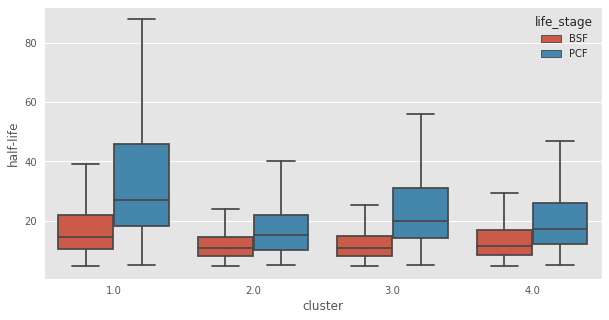

In [113]:
temp1 = hl_df[['BSF_half-life','label']]
temp1.columns = ['half-life','cluster']
temp1['life_stage']='BSF'
temp2 = hl_df[['PCF_half-life','label']]
temp2.columns = ['half-life','cluster']
temp2['life_stage']='PCF'
dataset_hl = pd.concat([temp1,temp2])

fig, ax = plt.subplots(figsize=(10,5))  
sns.boxplot(data=dataset_hl,x='cluster',
            y='half-life',hue='life_stage',
            showfliers=False,ax=ax)
plt.savefig('Figures/Figure_18.png')
plt.show()

In [114]:
dataset_hl.groupby(['cluster','life_stage'])['half-life'].mean().sort_values()

cluster  life_stage
2.0      BSF           12.364186
3.0      BSF           13.045360
4.0      BSF           14.375701
1.0      BSF           17.889393
2.0      PCF           18.917623
4.0      PCF           21.864598
3.0      PCF           26.382520
1.0      PCF           36.756202
Name: half-life, dtype: float64

## Protein Abundance Regression

### Load iBAQ values

In [115]:
list_pro = []
bsf_pro = pd.read_csv('InData/Proteomics/proteinGroups_BSF.zip',sep='\t')
bsf_pro = UT.clean_df(bsf_pro)
bsf_pro['gene_ids'] = [UT.clean_id(n) for n in bsf_pro['Protein IDs']]
bsf_pro = bsf_pro[['gene_ids','iBAQ H']]
bsf_pro.columns = ['gene_ids','iBAQ BSF']
bsf_pro.set_index('gene_ids',inplace=True)
list_pro.append(bsf_pro)

pcf_pro = pd.read_csv('InData/Proteomics/proteinGroups_PCF.zip',sep='\t')
pcf_pro = UT.clean_df(pcf_pro)
pcf_pro['gene_ids'] = [UT.clean_id(n) for n in pcf_pro['Protein IDs']]
pcf_pro = pcf_pro[['gene_ids','iBAQ H']]
pcf_pro.columns = ['gene_ids','iBAQ PCF']
pcf_pro.set_index('gene_ids',inplace=True)
list_pro.append(pcf_pro)

proteomic_df = pd.concat(list_pro,axis=1)
#proteomic_df = np.log10(proteomic_df)
proteomic_df.head()

starting from: (6449, 720)
removed  92 Protein Groups by: Only identified by site
tot  92  entries removed
---------------
removed  62 Protein Groups by: Reverse
tot  154  entries removed
---------------
removed  133 Protein Groups by: Potential contaminant
tot  287  entries removed
---------------
removed  221 Protein Groups by: Peptide counts (unique)
tot  508  entries removed
---------------
starting from: (6420, 337)
removed  185 Protein Groups by: Only identified by site
tot  185  entries removed
---------------
removed  61 Protein Groups by: Reverse
tot  246  entries removed
---------------
removed  113 Protein Groups by: Potential contaminant
tot  359  entries removed
---------------
removed  241 Protein Groups by: Peptide counts (unique)
tot  600  entries removed
---------------


,iBAQ BSF,iBAQ PCF
Tb05.5K5.210,37853000.0,NaN
Tb05.5K5.420,132770000.0,NaN
Tb06.3A7.270,NaN,2584500.0
Tb06.3A7.960,24142000.0,50793000.0
Tb07.11L3.100,1282400.0,NaN


### Load mRNA features

In [116]:
gene_df = cluster_dataset.copy()
gene_df['bsf_tot'] = np.log10(gene_df[['B_tot_1','B_tot_2','B_tot_3']].median(axis=1))
gene_df['pcf_tot'] = np.log10(gene_df[['P_tot_1','P_tot_2','P_tot_3']].median(axis=1))

gene_df['bsf_TC'] = np.log2(gene_df[['B_pol_1','B_pol_2','B_pol_3']].median(axis=1)/
                         gene_df[['B_sub_1','B_sub_2','B_sub_3']].median(axis=1) )

gene_df['pcf_TC'] = np.log2(gene_df[['P_pol_1','P_pol_2','P_pol_3']].median(axis=1)/
                         gene_df[['P_sub_1','P_sub_2','P_sub_3']].median(axis=1) )


gene_df['bsf_SUB'] = np.log10(gene_df[['B_sub_1','B_sub_2','B_sub_3']].median(axis=1))

gene_df['pcf_SUB'] = np.log10(gene_df[['P_sub_1','P_sub_2','P_sub_3']].median(axis=1))


gene_df = gene_df[['bsf_tot','pcf_tot','bsf_TC','pcf_TC','bsf_SUB','pcf_SUB']]
proteomic_df = proteomic_df.join(gene_df,how='left')
proteomic_df.head()

,iBAQ BSF,iBAQ PCF,bsf_tot,pcf_tot,bsf_TC,pcf_TC,bsf_SUB,pcf_SUB
Tb05.5K5.210,37853000.0,NaN,0.813135,0.734915,-0.040334,0.083301,0.838546,0.766488
Tb05.5K5.420,132770000.0,NaN,-0.599966,-0.941281,-0.379147,1.575954,0.036723,-0.403099
Tb06.3A7.270,NaN,2584500.0,0.768894,0.809368,0.298347,0.203989,0.641192,0.708883
Tb06.3A7.960,24142000.0,50793000.0,0.832261,0.805884,-0.148227,-0.202775,0.825697,0.820605
Tb07.11L3.100,1282400.0,NaN,0.941004,0.916977,0.020667,-0.128287,0.928751,0.959283


In [117]:
proteomic_df = proteomic_df.join(hl_df[['PCF_half-life','BSF_half-life']],how='left')
proteomic_df.head()

,iBAQ BSF,iBAQ PCF,bsf_tot,pcf_tot,bsf_TC,pcf_TC,bsf_SUB,pcf_SUB,PCF_half-life,BSF_half-life
Tb05.5K5.210,37853000.0,NaN,0.813135,0.734915,-0.040334,0.083301,0.838546,0.766488,NaN,NaN
Tb05.5K5.420,132770000.0,NaN,-0.599966,-0.941281,-0.379147,1.575954,0.036723,-0.403099,NaN,NaN
Tb06.3A7.270,NaN,2584500.0,0.768894,0.809368,0.298347,0.203989,0.641192,0.708883,NaN,NaN
Tb06.3A7.960,24142000.0,50793000.0,0.832261,0.805884,-0.148227,-0.202775,0.825697,0.820605,NaN,NaN
Tb07.11L3.100,1282400.0,NaN,0.941004,0.916977,0.020667,-0.128287,0.928751,0.959283,NaN,NaN


### Load Protein half-life

In [118]:
list_turn = []
bsf_turn = pd.read_csv('InData/Proteomics/Table 2.csv')
bsf_turn.set_index('protein_id',inplace=True)
bsf_turn = bsf_turn[['half_life']]
bsf_turn.columns = ['BSF_half_life_p']
list_turn.append(bsf_turn[['BSF_half_life_p']])

pcf_turn = pd.read_csv('InData/Proteomics/Table 3.csv')
pcf_turn.set_index('protein_id',inplace=True)
pcf_turn = pcf_turn[['half_life']]
pcf_turn.columns = ['PCF_half_life_p']
list_turn.append(pcf_turn[['PCF_half_life_p']])
turn_df = pd.concat(list_turn,axis=1)
turn_df.head()

,BSF_half_life_p,PCF_half_life_p
Tb04.24M18.150,NaN,NaN
Tb05.5K5.210,3.927583,NaN
Tb05.5K5.420,5.766479,NaN
Tb06.3A7.270,NaN,NaN
Tb06.3A7.960,5.583759,8.984693


In [119]:
proteomic_df = proteomic_df.join(turn_df,how='left')
proteomic_df.head()

,iBAQ BSF,iBAQ PCF,bsf_tot,pcf_tot,bsf_TC,pcf_TC,bsf_SUB,pcf_SUB,PCF_half-life,BSF_half-life,BSF_half_life_p,PCF_half_life_p
Tb05.5K5.210,37853000.0,NaN,0.813135,0.734915,-0.040334,0.083301,0.838546,0.766488,NaN,NaN,3.927583,NaN
Tb05.5K5.420,132770000.0,NaN,-0.599966,-0.941281,-0.379147,1.575954,0.036723,-0.403099,NaN,NaN,5.766479,NaN
Tb06.3A7.270,NaN,2584500.0,0.768894,0.809368,0.298347,0.203989,0.641192,0.708883,NaN,NaN,NaN,NaN
Tb06.3A7.960,24142000.0,50793000.0,0.832261,0.805884,-0.148227,-0.202775,0.825697,0.820605,NaN,NaN,5.583759,8.984693
Tb07.11L3.100,1282400.0,NaN,0.941004,0.916977,0.020667,-0.128287,0.928751,0.959283,NaN,NaN,4.815196,NaN


### Assemble Dataset

In [120]:
#ml_bsf.head()

In [121]:
ml_bsf = proteomic_df[['iBAQ BSF','bsf_tot','bsf_TC','BSF_half-life','BSF_half_life_p','bsf_SUB']]
ml_bsf.columns = ['ibaq_bsf','mRNA_bsf','TC_bsf','mRNA_hl_bsf','Prot_hl_bsf','SUB_bsf']
ml_bsf['Prot_hl_bsf']=np.log10(ml_bsf['Prot_hl_bsf']*60)
ml_bsf['mRNA_hl_bsf']=np.log10(ml_bsf['mRNA_hl_bsf'])
ml_bsf['ibaq_bsf'] = np.log10(ml_bsf['ibaq_bsf'])

ml_pcf = proteomic_df[['iBAQ PCF','pcf_tot','pcf_TC','PCF_half-life','PCF_half_life_p','pcf_SUB']]
ml_pcf.columns = ['ibaq_pcf','mRNA_pcf','TC_pcf','mRNA_hl_pcf','Prot_hl_pcf','SUB_pcf']
ml_pcf['Prot_hl_pcf']=np.log10(ml_pcf['Prot_hl_pcf']*60)
ml_pcf['ibaq_pcf'] = np.log10(ml_pcf['ibaq_pcf'])
ml_pcf['mRNA_hl_pcf']=np.log10(ml_pcf['mRNA_hl_pcf'])

ml_df=pd.concat([ml_bsf,ml_pcf],axis=1)
#print(ml_df.shape)
#ml_df=ml_df.dropna()#.replace(-np.inf, np.nan).replace(np.inf, np.nan).fillna(ml_df.mean())
print(ml_df.shape)
ml_df.head()
del ml_df['SUB_pcf']
del ml_df['SUB_bsf']
#ml_df.drop(['mRNA_bsf','mRNA_pcf'],axis=1,inplace=True)

(6517, 12)


In [122]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import scipy as sp
#test=test.dropna()
def plot_line(x,y,ax):
    linreg = sp.stats.linregress(x, y)
    ax.plot(x, linreg.slope*x + linreg.intercept,alpha=0.5)
    ax.text(0.1, 0.8, 'r2='+str(round(linreg.rvalue,2)), 
                               horizontalalignment='center',
               verticalalignment='center',
               transform=ax.transAxes,fontsize=16)

### BSF and PCF models

(2486, 5)
(1689, 5)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


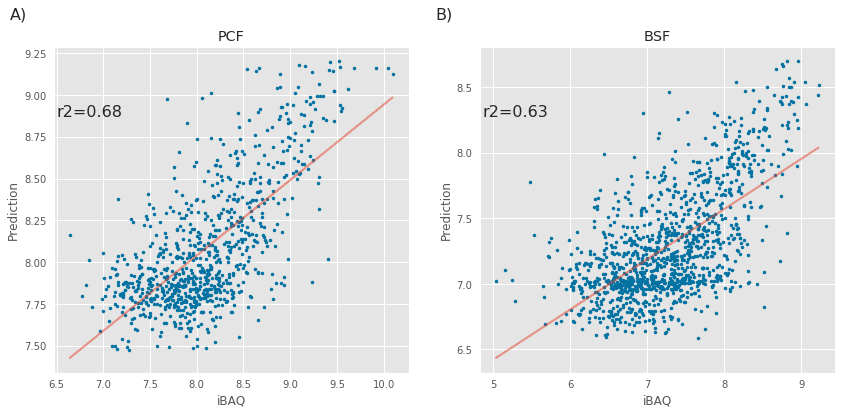

In [123]:
regr_bsf = RandomForestRegressor(max_depth=5, random_state=0,
                             min_samples_split=20,
                             min_samples_leaf=10,
                            criterion='mse')



X = ml_df.copy()
X = X[[n for n in X.columns if 'bsf' in n]]
X=X.dropna()
print(X.shape)

y=X['ibaq_bsf']
X=X.drop(['ibaq_bsf'],axis=1)
X.columns = [n.replace('_bsf','') for n in X.columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    random_state =1976)
regr_bsf.fit(X_train, y_train)
y_pred = regr_bsf.predict(X_test)


fig,axes=plt.subplots(figsize=(14,6),ncols=2)


ax=axes[1]
ax.plot(y_test,y_pred,'b.')
plot_line(y_test,y_pred,ax)

ax.set_xlabel('iBAQ')
ax.set_ylabel('Prediction')
ax.set_title('BSF')



regr_pcf = RandomForestRegressor(max_depth=5, random_state=0,
                             min_samples_split=20,
                             min_samples_leaf=10,
                            criterion='mse')

from sklearn.tree import DecisionTreeRegressor
#regr_pcf = DecisionTreeRegressor(random_state=0)

X = ml_df.copy()
X = X[[n for n in X.columns if 'pcf' in n]]
X=X.dropna()
print(X.shape)

y=X['ibaq_pcf']
X=X.drop(['ibaq_pcf'],axis=1)
X.columns = [n.replace('_pcf','') for n in X.columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    random_state =1976)
regr_pcf.fit(X_train, y_train)
y_pred = regr_pcf.predict(X_test)

ax=axes[0]
ax.plot(y_test,y_pred,'b.')
plot_line(y_test,y_pred,ax)
ax.set_xlabel('iBAQ')
ax.set_ylabel('Prediction')
ax.set_title('PCF')

UT.set_fig_label(axes[0],'A')
UT.set_fig_label(axes[1],'B')

plt.savefig('Figures/Figure_23.png')
plt.show()





### BSF Feature Importance

In [124]:
#X = ml_df.copy()
#X = X[[n for n in X.columns if 'bsf' in n]]
#X_test_p.columns

(2486, 5)
Index(['mRNA', 'TC', 'mRNA_hl', 'Prot_hl'], dtype='object')
Index(['mRNA', 'TC', 'mRNA_hl', 'Prot_hl'], dtype='object')
Index(['mRNA', 'TC', 'mRNA_hl', 'Prot_hl'], dtype='object')
[0.32326861 0.05619027 0.07610922 0.07260582]


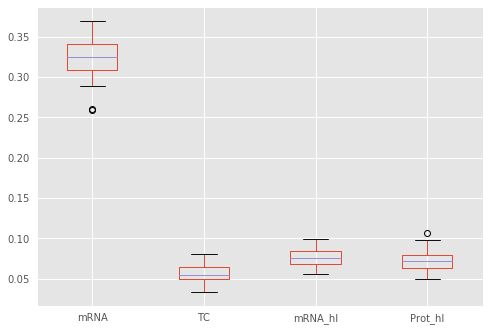

In [125]:
import shap


regr_bsf = RandomForestRegressor(max_depth=5, random_state=0,
                             min_samples_split=20,
                             min_samples_leaf=10,
                             criterion='mse')



X = ml_df.copy()
X = X[[n for n in X.columns if 'bsf' in n]]
X=X.dropna()
print(X.shape)

y=X['ibaq_bsf']
X=X.drop(['ibaq_bsf'],axis=1)
X.columns = [n.replace('_bsf','') for n in X.columns]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state =1976)
regr_bsf.fit(X_train_b, y_train_b)
print(X.columns)
print(X_train_b.columns)
print(X_test_b.columns)


#explainer_bsf = shap.TreeExplainer(regr_bsf)
#shap_values_bsf = explainer_bsf.shap_values(X_train_b)
#shap.summary_plot(shap_values_bsf, X_train_b,show=False)
#f = plt.gcf()
#f.set_size_inches(12,6)
#plt.title('BSF',fontsize=16)
#plt.savefig('Fig13.png')

from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance
 
result = permutation_importance(regr_bsf, X_test_b, y_test_b, 
                                n_repeats=50, random_state=0,scoring=make_scorer(r2_score))
print(result.importances_mean)
bsf_importance = pd.DataFrame(result.importances,index=X_test_b.columns)

fig,ax=plt.subplots()
bsf_importance.T.plot(kind='box',ax=ax)
plt.savefig('Figures/Figure_24.png')

### PCF feature importance

(1689, 5)
[0.08549086 0.09714801 0.21314691 0.09060287]


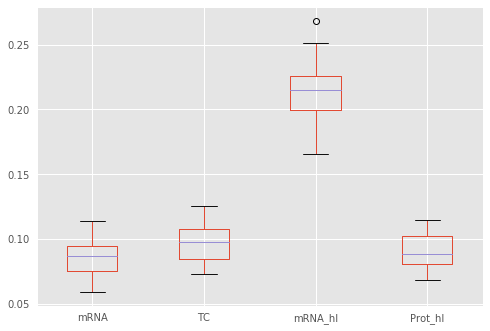

In [126]:
import shap


regr_pcf = RandomForestRegressor(max_depth=5, random_state=0,
                             min_samples_split=20,
                             min_samples_leaf=10,
                            criterion='mse')



X = ml_df.copy()
X = X[[n for n in X.columns if 'pcf' in n]]
X=X.dropna()
X = X[X['TC_pcf']>-1]
print(X.shape)

y=X['ibaq_pcf']
X=X.drop(['ibaq_pcf'],axis=1)
X.columns = [n.replace('_pcf','') for n in X.columns]


X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state =1976)
regr_pcf.fit(X_train_p, y_train_p)




#explainer_pcf = shap.TreeExplainer(regr_pcf)
#shap_values_pcf = explainer_bsf.shap_values(X_train_p)
#shap.summary_plot(shap_values_pcf, X_train_p,show=False)
#f = plt.gcf()
#f.set_size_inches(12,6)
#plt.title('PCF',fontsize=16)
#plt.savefig('Fig14.png')


#features = list(X.columns)
#importances = regr_pcf.feature_importances_
#indices = np.argsort(importances)
#plt.title('PCF')
#plt.barh(range(len(indices)), importances[indices], color='b', align='center')
#plt.yticks(range(len(indices)), [features[i] for i in indices])
#plt.xlabel('Relative Importance')
#plt.show()

result = permutation_importance(regr_pcf, X_test_p, y_test_p, n_repeats=50, random_state=0,
                                scoring=make_scorer(r2_score))
print(result.importances_mean)
pcf_importance = pd.DataFrame(result.importances,index=X_test_p.columns)

fig,ax=plt.subplots()
pcf_importance.T.plot(kind='box',ax=ax)
plt.savefig('Figures/Figure_25.png')

In [127]:
#infile='proteomics/CDS/peptides.zip'
#bsf_cds_pep = pd.read_csv(infile,sep='\t')


In [128]:
#bsf_cds_pep['Proteins'] =bsf_cds_pep['Proteins'].astype(str)
#bsf_cds_pep['name'] = [n.split(';')[0] for n in bsf_cds_pep['Proteins']]




## Finding new protein coding genes

In [129]:
!gtf2bed < 'InData/tb927_3_ks_st_sc_st_tr.gtf' > 'tb927_3_ks_st_sc_st_tr.bed'
!sort-bed < 'tb927_3_ks_st_sc_st_tr.bed' - > 'tb927_3_ks_st_sc_st_tr_sorted.bed'
outfile = open('tb927_3_ks_st_sc_st_tr_sorted_filter.bed','w')
for line in open('tb927_3_ks_st_sc_st_tr_sorted.bed'):
    if 'KS17' in line:
        outfile.write(line)
    elif 'MSTRG' in line:
        outfile.write(line)
    elif 'TRY.' in line:
        outfile.write(line)
    else:
        pass
outfile.close()

### process proteomics

In [130]:
def process_peps(infile='proteomics/CDS/peptides.zip'):
    bsf_cds_pep = pd.read_csv(infile,sep='\t')
    bsf_cds_pep['Proteins'] =bsf_cds_pep['Proteins'].astype(str)
    bsf_cds_pep['Reverse'] = bsf_cds_pep['Reverse'].astype(str)
    bsf_cds_pep = bsf_cds_pep[bsf_cds_pep['Reverse'] != '+' ]
    bsf_cds_pep['Potential contaminant'] = bsf_cds_pep['Potential contaminant'].astype(str)
    bsf_cds_pep = bsf_cds_pep[bsf_cds_pep['Potential contaminant'] != '+' ]

    bsf_cds_pep['my_name'] = [n.split(';')[0] for n in bsf_cds_pep['Proteins']]
    bsf_cds_pep['my_chro'] = [n.split('-')[0] for n in bsf_cds_pep['my_name']]
    bsf_cds_pep['my_frame'] = [n.split('-')[1] for n in bsf_cds_pep['my_name']]
    bsf_cds_pep['my_start'] = [n.split('-')[2] for n in bsf_cds_pep['my_name']]
    bsf_cds_pep['my_end'] = [n.split('-')[3] for n in bsf_cds_pep['my_name']]

    bsf_cds_pep['my_start']=bsf_cds_pep['my_start'].astype(int)
    bsf_cds_pep['my_end']=bsf_cds_pep['my_end'].astype(int)

    bsf_cds_pep['dif'] = bsf_cds_pep['my_start']-bsf_cds_pep['my_end']
    bsf_cds_pep['new_start'] = bsf_cds_pep[['my_start','my_end']].min(axis=1).astype(int)
    bsf_cds_pep['new_end'] = bsf_cds_pep[['my_start','my_end']].max(axis=1).astype(int)
    return bsf_cds_pep

bsf_cds_pep =  process_peps(infile='InData/Proteomics/peptides_bsf.zip')
pcf_cds_pep = process_peps(infile='InData/Proteomics/peptides_pcf.zip')

In [131]:
bsf_cds_pep=pd.concat([bsf_cds_pep,pcf_cds_pep])

In [132]:
bsf_cds_pep[['Start position','End position','Proteins','my_chro','my_start',
             'my_end','new_start','new_end','dif','my_frame','Sequence']].head()

,Start position,End position,Proteins,my_chro,my_start,my_end,new_start,new_end,dif,my_frame,Sequence
0,20.0,41.0,Tb927_05_v5.1-3-586011-591284,Tb927_05_v5.1,586011,591284,586011,591284,-5273,3,AAAAAAAAEVESGIAGVEETLR
1,20.0,42.0,Tb927_05_v5.1-3-586011-591284,Tb927_05_v5.1,586011,591284,586011,591284,-5273,3,AAAAAAAAEVESGIAGVEETLRR
2,612.0,623.0,Tb927_08_v5.1-1-1802833-1806903,Tb927_08_v5.1,1802833,1806903,1802833,1806903,-4070,1,AAAAAFQESVGR
3,426.0,458.0,Tb927_11_bin_v5.1-6-1334239-1332284;Tb927_01_v...,Tb927_11_bin_v5.1,1334239,1332284,1332284,1334239,1955,6,AAAAATISGAVPMHSLQASGGHASGADDSTCER
4,426.0,464.0,Tb927_11_bin_v5.1-6-1334239-1332284;Tb927_01_v...,Tb927_11_bin_v5.1,1334239,1332284,1332284,1334239,1955,6,AAAAATISGAVPMHSLQASGGHASGADDSTCERICAALK


In [133]:
bsf_cds_pep[(bsf_cds_pep['my_chro']=='Tb927_10_v5.1')
            &(bsf_cds_pep['my_start']>2944807)
            &(bsf_cds_pep['my_end']<2945348)][['Start position','End position','Proteins','my_chro','my_start',
             'my_end','new_start','new_end','dif','my_frame','Sequence']].head()

,Start position,End position,Proteins,my_chro,my_start,my_end,new_start,new_end,dif,my_frame,Sequence
3437,95.0,102.0,Tb927_10_v5.1-2-2944808-2945347,Tb927_10_v5.1,2944808,2945347,2944808,2945347,-539,2,ALHVNILR
16193,139.0,149.0,Tb927_10_v5.1-2-2944808-2945347,Tb927_10_v5.1,2944808,2945347,2944808,2945347,-539,2,EKPLQVSYCNK
26981,111.0,133.0,Tb927_10_v5.1-2-2944808-2945347,Tb927_10_v5.1,2944808,2945347,2944808,2945347,-539,2,GSAFVEYGSTEEADCAILALHNR
40129,164.0,177.0,Tb927_10_v5.1-2-2944808-2945347,Tb927_10_v5.1,2944808,2945347,2944808,2945347,-539,2,LHDENPANPAPPQR
59561,150.0,158.0,Tb927_10_v5.1-2-2944808-2945347,Tb927_10_v5.1,2944808,2945347,2944808,2945347,-539,2,SELISEFGR


### get peptide genomic coords

In [134]:
#bsf_cds_pep = bk.copy()
#bsf_cds_pep = bsf_cds_pep.head(50)
starts = []
ends = []
for pep_start, pep_end, genomic_start, genomic_end, diff in zip(bsf_cds_pep['Start position'],bsf_cds_pep['End position'],
                    bsf_cds_pep['my_start'],bsf_cds_pep['my_end'],bsf_cds_pep['dif']):
    
    
    #e: difference, are in the + or - strand
    #a: start of peptide sequence in the predicted protein
    #b: end of peptide sequence in the predicted protein
    #c: genomic start of the predicted protein
    #b: genomic end of the predicted protein
    
    #the length of the predicted peptide sequence
    pep_length = abs(pep_start-pep_end)*3
    #print(pep_length)
    #we are in the reverse strand
    if diff > 0 :
        #oddities with python starting to count at 0
        #new_start = c-(b)+1
        new_start = genomic_start-(pep_start*3)+3
        new_end = new_start-pep_length-2 
        
    #we are in the forward strand
    if diff < 0 :
        #print('m here')
        new_start = genomic_start+(pep_start*3)-3
        #oddities with python starting to count at 0
        new_end = new_start + pep_length +2
        
    starts.append(new_start)
    ends.append(new_end)
    #print(a,b,c,d,e,new_start,new_end)
    
    
bsf_cds_pep['pep_start'] = starts
bsf_cds_pep['pep_end'] = ends
bsf_cds_pep['pep_start2'] = bsf_cds_pep[['pep_start','pep_end']].min(axis=1).astype(int)
bsf_cds_pep['pep_end2'] = bsf_cds_pep[['pep_start','pep_end']].max(axis=1).astype(int)


bsf_cds_pep['names']=(bsf_cds_pep['my_name']+'_'+
                      bsf_cds_pep['pep_start2'].astype(str)+'-'+
                      bsf_cds_pep['pep_end2'].astype(str)+'-'+bsf_cds_pep['Sequence']+'-bsf')


bsf_cds_pep[['Start position','End position','Proteins','my_chro','my_start',
             'my_end','new_start','new_end','dif','my_frame','Sequence',
            'pep_start','pep_end','pep_start2','pep_end2','names','dif']].head(20)



,Start position,End position,Proteins,my_chro,my_start,my_end,new_start,new_end,dif,my_frame,Sequence,pep_start,pep_end,pep_start2,pep_end2,names,dif
0,20.0,41.0,Tb927_05_v5.1-3-586011-591284,Tb927_05_v5.1,586011,591284,586011,591284,-5273,3,AAAAAAAAEVESGIAGVEETLR,586068.0,586133.0,586068,586133,Tb927_05_v5.1-3-586011-591284_586068-586133-AA...,-5273
1,20.0,42.0,Tb927_05_v5.1-3-586011-591284,Tb927_05_v5.1,586011,591284,586011,591284,-5273,3,AAAAAAAAEVESGIAGVEETLRR,586068.0,586136.0,586068,586136,Tb927_05_v5.1-3-586011-591284_586068-586136-AA...,-5273
2,612.0,623.0,Tb927_08_v5.1-1-1802833-1806903,Tb927_08_v5.1,1802833,1806903,1802833,1806903,-4070,1,AAAAAFQESVGR,1804666.0,1804701.0,1804666,1804701,Tb927_08_v5.1-1-1802833-1806903_1804666-180470...,-4070
3,426.0,458.0,Tb927_11_bin_v5.1-6-1334239-1332284;Tb927_01_v...,Tb927_11_bin_v5.1,1334239,1332284,1332284,1334239,1955,6,AAAAATISGAVPMHSLQASGGHASGADDSTCER,1332964.0,1332866.0,1332866,1332964,Tb927_11_bin_v5.1-6-1334239-1332284_1332866-13...,1955
4,426.0,464.0,Tb927_11_bin_v5.1-6-1334239-1332284;Tb927_01_v...,Tb927_11_bin_v5.1,1334239,1332284,1332284,1334239,1955,6,AAAAATISGAVPMHSLQASGGHASGADDSTCERICAALK,1332964.0,1332848.0,1332848,1332964,Tb927_11_bin_v5.1-6-1334239-1332284_1332848-13...,1955
5,364.0,393.0,Tb927_01_v5.1-3-717978-720599,Tb927_01_v5.1,717978,720599,717978,720599,-2621,3,AAAAAVVETVAQTSTKPPPPLFDTDVEEGK,719067.0,719156.0,719067,719156,Tb927_01_v5.1-3-717978-720599_719067-719156-AA...,-2621
6,116.0,139.0,Tb927_03_v5.1-3-1499100-1500287,Tb927_03_v5.1,1499100,1500287,1499100,1500287,-1187,3,AAAADCAADGRLDEAVDLLAQALR,1499445.0,1499516.0,1499445,1499516,Tb927_03_v5.1-3-1499100-1500287_1499445-149951...,-1187
7,147.0,159.0,Tb927_11_bin_v5.1-3-571173-572531;Tb927_10_v5....,Tb927_11_bin_v5.1,571173,572531,571173,572531,-1358,3,AAAADHEMNVYEK,571611.0,571649.0,571611,571649,Tb927_11_bin_v5.1-3-571173-572531_571611-57164...,-1358
8,92.0,115.0,Tb927_05_v5.1-4-1050101-1048047,Tb927_05_v5.1,1050101,1048047,1048047,1050101,2054,4,AAAADTSTASETEDVFANQPEAMK,1049828.0,1049757.0,1049757,1049828,Tb927_05_v5.1-4-1050101-1048047_1049757-104982...,2054
9,64.0,72.0,Tb927_05_v5.1-1-865399-869598,Tb927_05_v5.1,865399,869598,865399,869598,-4199,1,AAAADVFLR,865588.0,865614.0,865588,865614,Tb927_05_v5.1-1-865399-869598_865588-865614-AA...,-4199


In [135]:
bsf_cds_pep = bsf_cds_pep[['my_chro','pep_start2','pep_end2','names']]
bsf_cds_pep = bsf_cds_pep[(bsf_cds_pep['pep_start2']>0)&(bsf_cds_pep['pep_end2']>0)]
bsf_cds_pep.to_csv('pep_cds.bed', header=False, index=False,sep='\t')
bsf_cds_pep.head(5)

,my_chro,pep_start2,pep_end2,names
0,Tb927_05_v5.1,586068,586133,Tb927_05_v5.1-3-586011-591284_586068-586133-AA...
1,Tb927_05_v5.1,586068,586136,Tb927_05_v5.1-3-586011-591284_586068-586136-AA...
2,Tb927_08_v5.1,1804666,1804701,Tb927_08_v5.1-1-1802833-1806903_1804666-180470...
3,Tb927_11_bin_v5.1,1332866,1332964,Tb927_11_bin_v5.1-6-1334239-1332284_1332866-13...
4,Tb927_11_bin_v5.1,1332848,1332964,Tb927_11_bin_v5.1-6-1334239-1332284_1332848-13...


### Create pep track

In [136]:
bsf_cds_pep['dummy']=1
bsf_cds_pep[['my_chro','pep_start2','pep_end2','dummy']
           ].to_csv('all_pepe.bed',index=False,header=False,sep='\t')

### find novel protein coding genes

In [137]:
!sort-bed < 'pep_cds.bed' - > 'pep_cds_sorted.bed'

In [138]:
!bedextract  'pep_cds_sorted.bed' tb927_3_ks_st_sc_st_tr_sorted_filter.bed > cds.filtered.bed

In [139]:
!bedtools intersect -wo -a tb927_3_ks_st_sc_st_tr_sorted_filter.bed \
                             -b cds.filtered.bed  > cds.filtered_closest2.bed

In [140]:
innew = pd.read_table('cds.filtered_closest2.bed',header=None)
innew.columns = [
    'chro','start','end','name','score','score2',
    'ref','gene_feature','score3','gene_ref',
    'chro2','pep_start','pep_end','pep_ref','pep_size'
]
innew=innew[innew['gene_feature']=='transcript']
print(innew.groupby('name').size().shape)
innew.groupby('name').size()

(101,)


name
KS17gene_1150a     1
KS17gene_1625a     1
KS17gene_1743a     2
KS17gene_1898a     3
KS17gene_2001a     1
                  ..
TRY.854           15
TRY.862            5
TRY.871            3
TRY.878           10
TRY.884           32
Length: 101, dtype: int64

In [141]:
main_chrs = ['Tb927_{}_v5.1'.format(c) for c in ['01','02','03','04','05','06','07','08','09','10','11']]

innew[innew['chro'].isin(main_chrs)].groupby(['chro','name']).size()

chro           name          
Tb927_02_v5.1  KS17gene_245a     9
               KS17gene_265a     4
               KS17gene_4445a    3
               MSTRG.102         4
               MSTRG.94          3
Tb927_03_v5.1  KS17gene_4643a    1
Tb927_04_v5.1  KS17gene_4953a    1
Tb927_06_v5.1  KS17gene_1150a    1
               MSTRG.191         1
Tb927_07_v5.1  KS17gene_1625a    1
               MSTRG.240         3
               TRY.375           2
Tb927_08_v5.1  KS17gene_1743a    2
               KS17gene_1898a    3
               KS17gene_2001a    1
               KS17gene_2052a    4
               KS17gene_6275a    1
               KS17gene_6299a    1
               KS17gene_6391a    1
Tb927_09_v5.1  KS17gene_2249a    1
               KS17gene_2334a    5
               KS17gene_2338a    1
               KS17gene_6998a    2
               KS17gene_7003a    6
Tb927_10_v5.1  KS17gene_2781a    1
               KS17gene_2782a    1
               MSTRG.443         1
               TRY.736   

In [142]:
print(innew[innew['chro'].isin(main_chrs)].groupby('name').size().shape)
innew[innew['chro'].isin(main_chrs)].groupby('name').size()

(30,)


name
KS17gene_1150a    1
KS17gene_1625a    1
KS17gene_1743a    2
KS17gene_1898a    3
KS17gene_2001a    1
KS17gene_2052a    4
KS17gene_2249a    1
KS17gene_2334a    5
KS17gene_2338a    1
KS17gene_245a     9
KS17gene_265a     4
KS17gene_2781a    1
KS17gene_2782a    1
KS17gene_4445a    3
KS17gene_4643a    1
KS17gene_4953a    1
KS17gene_6275a    1
KS17gene_6299a    1
KS17gene_6391a    1
KS17gene_6998a    2
KS17gene_7003a    6
KS17gene_8114a    1
KS17gene_8518a    4
MSTRG.102         4
MSTRG.191         1
MSTRG.240         3
MSTRG.443         1
MSTRG.94          3
TRY.375           2
TRY.736           1
dtype: int64

In [143]:
innew['dummy']=1
innew[['chro2','pep_start','pep_end','dummy']].to_csv('new_genes.bed',index=False,header=False,sep='\t')

In [144]:
from Bio import SeqIO
from Bio.Seq import Seq

chr_dict = {}
fasta_sequences = SeqIO.parse(open('genomes/tb927_3/tb927_3.fasta'),'fasta')
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    chr_dict[name]=sequence
    
def get_seq(X, chr_dict):
    temp_seq = chr_dict[X['ref_chro']]
    temp_seq = temp_seq[X['ref_start']+1:X['ref_end']]
    return temp_seq


## Find closest 5'

In [145]:
def get_gene(indata):
    indata = indata[-1].split(';')
    res = {}
    #print(indata)
    for n in indata:
        if 'gene_id' in n:
            n=n.strip()
            res[n.split(' ')[0].strip()]=n.split(' ')[1].strip('\"').strip('\'').strip()
    #print(res)
    return res['gene_id']

inbed = pd.read_csv('tb927_3_ks_st_sc_st_tr_sorted.bed',sep='\t')
inbed.columns = ['chro','start','end','gene_id','a','orient','source','ftype','e','f']
inbed=inbed[inbed['ftype']=='transcript']
inbed =inbed.reset_index()
del inbed['index']
#inbed =inbed.reset_index()
#inbed = inbed.set_index('gene_id')
inbed['gene_plus1'] = inbed['gene_id'].shift(+1)
inbed['gene_plus2'] = inbed['gene_id'].shift(+2)
inbed['orient_plus1'] = inbed['orient'].shift(+1)
inbed['orient_plus2'] = inbed['orient'].shift(+2)
inbed['gene_minus1'] = inbed['gene_id'].shift(-1)
inbed['orient_minus1'] = inbed['orient'].shift(-1)
inbed['gene_minus2'] = inbed['gene_id'].shift(-2)
inbed['orient_minus2'] = inbed['orient'].shift(-2)
inbed.head()

,chro,start,end,gene_id,a,orient,source,ftype,e,f,gene_plus1,gene_plus2,orient_plus1,orient_plus2,gene_minus1,orient_minus1,gene_minus2,orient_minus2
0,11L3_v3,0,2768,MSTRG.1,1000,.,StringTie,transcript,.,"gene_id ""MSTRG.1""; transcript_id ""MSTRG.1.1"";",NaN,NaN,NaN,NaN,MSTRG.2,.,TRY.1,-
1,11L3_v3,3000,5482,MSTRG.2,1000,.,StringTie,transcript,.,"gene_id ""MSTRG.2""; transcript_id ""MSTRG.2.1"";",MSTRG.1,NaN,.,NaN,TRY.1,-,TRY.2,-
2,11L3_v3,5482,6228,TRY.1,1000,-,StringTie,transcript,.,"gene_id ""TRY.1""; transcript_id ""TRY.1.1"";",MSTRG.2,MSTRG.1,.,.,TRY.2,-,TRY.3,-
3,11L3_v3,6598,8129,TRY.2,1000,-,StringTie,transcript,.,"gene_id ""TRY.2""; transcript_id ""TRY.2.1"";",TRY.1,MSTRG.2,-,.,TRY.3,-,MSTRG.3,.
4,11L3_v3,8332,9722,TRY.3,1000,-,StringTie,transcript,.,"gene_id ""TRY.3""; transcript_id ""TRY.3.1"";",TRY.2,TRY.1,-,-,MSTRG.3,.,TRY.4,-


In [146]:
for_list = inbed[(inbed['orient_minus1']=='+')#&
     #inbed['gene_id'].isin(common_genes)&
     #inbed['gene_minus1'].str.startswith('Tb')
                
                ][['gene_id','gene_minus1','orient_minus1']]

rev_list = inbed[(inbed['orient_plus1']=='-')#&
#      inbed['gene_id'].isin(common_genes)&
     #inbed['gene_plus1'].str.startswith('Tb')
                
                ][['gene_id','gene_plus1','orient_plus1']]
rev_list.columns = ['gene_id','reg_gene','orient']
for_list.columns = ['gene_id','reg_gene','orient']
merge_list = pd.concat([for_list,rev_list])


In [147]:
print(merge_list.shape)
merge_list.tail()

(14857, 3)


,gene_id,reg_gene,orient
15841,Tb11.1600,Tb11.1590,-
15842,Tb11.1630,Tb11.1600,-
15847,Tb11.1680,Tb11.1670,-
15848,MSTRG.999,Tb11.1680,-
15868,MSTRG.1012,Tb11.1800,-


### BSF and PCF

In [148]:
table_pol_v_sub.loc[['KS17gene_1749a','KS17gene_4295a','KS17gene_3137a']]

,logFC,logCPM,LR,PValue,FDR,log_PValue,log_FDR
KS17gene_1749a,1.078756,6.146052,418.650208,4.800049e-93,5.563335e-92,92.318754,91.254665
KS17gene_4295a,0.138912,1.380045,0.805346,3.694999e-01,3.959928e-01,0.432386,0.402313
KS17gene_3137a,2.238743,3.080815,378.601073,2.509176e-84,2.445193e-83,83.600469,82.611687


In [149]:
regulatory_df = merge_list[
    (merge_list['gene_id'].str.startswith('KS')#)|
    #(merge_list['gene_id'].str.startswith('TRY.'))|
    #(merge_list['gene_id'].str.startswith('MSTRG.')
    )
].drop_duplicates('gene_id').set_index('gene_id').join(
    table_pol_v_sub,how='inner').reset_index().rename({'index':'gene_id'},axis=1).drop_duplicates(
    'reg_gene').set_index('reg_gene').join(table_pol_v_sub,how='inner',rsuffix='_reg').reset_index(
).rename({'index':'reg_gene'},axis=1).set_index('gene_id')

regulatory_df = regulatory_df[regulatory_df['reg_gene'].str.startswith('Tb')]


In [150]:
regulatory_df.head()

,reg_gene,orient,logFC,logCPM,LR,PValue,FDR,log_PValue,log_FDR,logFC_reg,logCPM_reg,LR_reg,PValue_reg,FDR_reg,log_PValue_reg,log_FDR_reg
gene_id,,,,,,,,,,,,,,,,
KS17gene_5a,Tb05.5K5.250,+,0.078377,3.296331,0.386388,5.342039e-01,5.599439e-01,0.272293,0.251855,-0.906861,1.906779,43.108663,5.178245e-11,9.374009e-11,10.285817,10.028075
KS17gene_4422a,Tb927.1.110,+,2.401263,6.903541,1184.588983,1.363205e-259,2.267731e-257,258.865439,256.644408,-0.602597,7.139090,46.444482,9.425141e-12,1.747364e-11,11.025712,10.757616
KS17gene_30a,Tb927.1.275,+,1.228387,5.254546,375.737278,1.054475e-83,1.012926e-82,82.976964,81.994422,1.839111,5.659192,749.948640,4.116889e-165,1.577583e-163,164.385431,162.802008
KS17gene_33a,Tb927.1.300,+,2.543118,6.537824,604.417422,1.832232e-133,4.035477e-132,132.737020,131.394105,2.325758,6.853580,806.122630,2.517082e-177,1.182443e-175,176.599103,174.927220
KS17gene_34a,Tb927.1.410,+,3.499395,6.534084,1554.714588,0.000000e+00,0.000000e+00,inf,inf,-1.210022,5.496030,348.389040,9.504983e-78,8.140549e-77,77.022049,76.089346


In [151]:
#inbed = pd.read_csv('tb927_3_ks_st_sc_st_tr_sorted.bed',sep='\t')
#inbed.columns = ['chro','start','end','gene_id','a','orient','source','ftype','e','f']
#inbed=inbed[inbed['ftype']=='transcript']
#inbed.columns = ['ref_'+n for n in inbed.columns]
#inbed=inbed.drop_duplicates(subset=['ref_gene_id'])
#inbed.set_index('ref_gene_id',inplace=True)
#inbed.head()

In [152]:
#regulatory_df = regulatory_df.join(inbed,how='inner')

In [153]:
ptr = pd.read_csv('PTR.txt',sep='\t')
ptr = ptr.drop_duplicates('gene_id')
#ptr.set_index('gene_id',inplace=True)
ptr.head()

,gene_id,reg_type
0,Tb927.7.2660,increase
1,Tb927.8.4540,increase
2,Tb927.11.11770,increase
3,Tb927.1.3070,increase
4,Tb927.11.3100,increase


In [154]:
print(regulatory_df.shape)
regulatory_df=regulatory_df.reset_index().merge(
    ptr, how='left', left_on='reg_gene', right_on='gene_id').drop(
    'gene_id_y',axis=1).rename({'gene_id_x':'gene_ks',
                               'reg_gene':'gene_sensitive'
                               },axis=1).drop('orient',axis=1)

regulatory_df.drop([n for n in regulatory_df.columns if 'log_' in n],axis=1,inplace=True)
#regulatory_df.columns = [n.replace('_reg','_sensitive') for n in regulatory_df.columns]
regulatory_df.drop([n for n in regulatory_df.columns if '_reg' in n],axis=1,inplace=True)
print(regulatory_df.shape)

(1489, 16)
(1489, 8)


In [155]:
regulatory_df['desc']=[desc_dict.get(n,'none') for n in regulatory_df['gene_sensitive']]

In [156]:
selected = regulatory_df[ (regulatory_df['logFC']>0) &
              (regulatory_df['logCPM']>1) & 
              (regulatory_df['FDR']<0.01) ]['reg_type']
selected.value_counts()

increase    16
decrease    10
Name: reg_type, dtype: int64

In [157]:
regulatory_df['selected'] = [1 if n in selected.dropna().index.values else 0 for n in regulatory_df.index.values]

In [158]:
regulatory_df.to_csv('Tables/Table_6.csv')

## CDS analysis

In [159]:
df = pd.read_csv('InData/tb927_3_ks_counts_cds.txt',index_col=[0],comment='#',sep='\t')
data_col = df.columns[5:25]
df.head()

,Chr,Start,End,Strand,Length,B_tot_1/res2/B_tot_1/B_tot_1_sorted.bam,B_tot_2/res2/B_tot_2/B_tot_2_sorted.bam,B_tot_3/res2/B_tot_3/B_tot_3_sorted.bam,B_pol_1/res2/B_pol_1/B_pol_1_sorted.bam,B_pol_2/res2/B_pol_2/B_pol_2_sorted.bam,...,B_sub_3/res2/B_sub_3/B_sub_3_sorted.bam,P_tot_1/res2/P_tot_1/P_tot_1_sorted.bam,P_tot_2/res2/P_tot_2/P_tot_2_sorted.bam,P_tot_3/res2/P_tot_3/P_tot_3_sorted.bam,P_pol_1/res2/P_pol_1/P_pol_1_sorted.bam,P_pol_2/res2/P_pol_2/P_pol_2_sorted.bam,P_pol_3/res2/P_pol_3/P_pol_3_sorted.bam,P_sub_1/res2/P_sub_1/P_sub_1_sorted.bam,P_sub_2/res2/P_sub_2/P_sub_2_sorted.bam,P_sub_3/res2/P_sub_3/P_sub_3_sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
Tb10.v4.0073,tryp_X-188b09.p2kB601,929,1489,+,561,1,1,0,0,0,...,2,0,1,2,0,0,0,0,0,0
Tb10.v4.0074,tryp_X-188b09.p2kB601,2775,3452,+,678,0,1,1,1,0,...,1,0,0,0,0,0,0,0,0,0
Tb10.v4.0075,tryp_X-188b09.p2kB601,3781,5223,+,1443,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Tb10.v4.0076,tryp_X-188b09.p2kB601,6264,7721,+,1458,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0077,tryp_X-188b09.p2kB601,9669,10955,+,1287,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [160]:
print(df.shape)
#indata = df[df['sumValues']>200][data_col]
indata = df[data_col]
indata.columns = [n.split('/')[0] for  n in indata.columns]
indata.head()
print(indata.shape)
indata.reset_index(inplace=True)
indata.head()

(13937, 23)
(13937, 18)


,Geneid,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
0,Tb10.v4.0073,1,1,0,0,0,0,1,0,2,0,1,2,0,0,0,0,0,0
1,Tb10.v4.0074,0,1,1,1,0,0,1,2,1,0,0,0,0,0,0,0,0,0
2,Tb10.v4.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Tb10.v4.0076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Tb10.v4.0077,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [161]:
indata = indata.groupby('Geneid').sum().reset_index()
indata = indata.drop_duplicates('Geneid')
#indata.set_index('Geneid',inplace=True)
print(indata.shape)
indata.head()

(13027, 19)


,Geneid,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
0,KS17gene_1000a,1658,1690,1536,2040,1966,2302,1398,1058,1112,1964,1665,1222,1587,2153,1928,1305,1626,1409
1,KS17gene_1005a,350,450,385,376,333,494,146,136,120,448,372,255,323,340,344,219,392,269
2,KS17gene_1009a,144,182,210,90,125,90,75,63,71,137,145,103,74,98,113,56,80,56
3,KS17gene_1016a,1937,1954,1706,2104,1980,2358,2382,1693,2642,2667,2495,1711,1554,2002,1778,2042,2551,2435
4,KS17gene_1022a,509,596,485,588,681,776,1344,1234,1168,546,393,256,212,340,315,352,610,537


In [162]:
%%R -i indata
rownames(indata) <- indata$Geneid
indata <- subset(indata, select = -c(Geneid))
library("limma") 
library("edgeR")

In [163]:
%%R
group <- factor(c(
    'Btot','Btot','Btot',
    'Bpol','Bpol','Bpol',
    'Bsub','Bsub','Bsub',
    'Ptot','Ptot','Ptot',
    'Ppol','Ppol','Ppol',
    'Psub','Psub','Psub'))
y <- DGEList(counts=indata,group=group)
keep <- filterByExpr(y)
y <- y[keep,,keep.lib.sizes=FALSE]
y <- calcNormFactors(y)
design <- model.matrix(~group)
y <- estimateDisp(y,design)
cpm_df <- cpm(y)
genes = row.names(y)
head(genes)

[1] "KS17gene_1000a" "KS17gene_1005a" "KS17gene_1009a" "KS17gene_1016a"
[5] "KS17gene_1022a" "KS17gene_1024a"


In [164]:
%R -o cpm_df,genes
indata.set_index('Geneid',inplace=True)
out_df = pd.DataFrame(cpm_df,index=genes,columns=indata.columns)

out_df.head()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
KS17gene_1000a,59.984718,65.884992,63.693388,88.380152,81.614585,92.012831,50.357645,44.741420,46.343857,61.888012,58.200406,57.051574,89.206001,97.956040,92.124816,52.853981,50.854838,49.988411
KS17gene_1005a,12.662637,17.543341,15.964814,16.289675,13.823834,19.745586,5.259096,5.751260,5.001136,14.117021,13.003334,11.905198,18.155979,15.469138,16.437208,8.869749,12.260207,9.543565
KS17gene_1009a,5.209770,7.095307,8.708080,3.899124,5.189127,3.597374,2.701590,2.664187,2.959005,4.317035,5.068504,4.808766,4.159574,4.458751,5.399432,2.268064,2.502083,1.986764
KS17gene_1016a,70.078649,76.177085,70.742787,91.152863,82.195767,94.251197,85.802512,71.594729,110.108337,84.040392,87.213221,79.881542,87.351055,91.085923,84.957429,82.703317,79.785174,86.388773
KS17gene_1022a,18.415092,23.235181,20.111519,25.474279,28.270362,31.017358,48.412500,52.184227,48.677720,17.205120,13.737393,11.951885,11.916618,15.469138,15.051513,14.256399,19.078383,19.051651


In [165]:
pcf_ribo = pd.read_csv('InData/PolisomeLiterature/PCF.csv',index_col=[0])
pcf_ribo.columns = ['PCF_'+n for n in pcf_ribo.columns]
bsf_ribo = pd.read_csv('InData/PolisomeLiterature/BSF.csv',index_col=[0])
bsf_ribo.columns = ['BSF_'+n for n in bsf_ribo.columns]
ribo = pcf_ribo.join(bsf_ribo,how='outer')
ribo = ribo.reset_index()
ribo=ribo.replace('#DIV/0!',np.nan)
ribo_lookup = pd.read_csv('InData/PolisomeLiterature/GeneByLocusTag_Summary.txt',sep='\t')
ribo_lookup.head()
ribo_df = ribo_lookup.merge(ribo,left_on='Input ID',right_on='2013Latest_numbers',how='outer')
#hl_df.head()
ribo_df.set_index('Gene ID',inplace=True)
ribo_df.head()

,Genomic Location (Gene),Product Description,Gene Type,Input ID,Unnamed: 5,2013Latest_numbers,PCF_Annotation,PCF_Class,PCF_Orthologue count,PCF_ORF length,...,BSF_BS RNAs/cell pA+ fragments,BSF_Log 2 BS RNAs/cell pA+ fragments,BSF_RPM Ribosome profiling,BSF_RPM Ribsome profiling x orthogue count,BSF_Ribosomes/cell/gene,BSF_Ribosomes/mRNA,BSF_Ribosomes/kb BS,BSF_Fraction in polysomes,BSF_mRNA abundance BS/PC (Silicotryp),"BSF_ribosomes/kb, BS/PC"
Gene ID,,,,,,,,,,,,,,,,,,,,,
Tb927.1.1000,"Tb927_01_v5.1:289,877..291,155(+)",developmentally regulated phosphoprotein,protein coding,Tb927.1.1000,NaN,Tb927.1.1000,developmentally regulated phosphoprotein (dr6),Mito.pathway,1.0,1263.0,...,2.05,1.04,29.16,29.16,2.56,1.85,1.46,0.615,0.89,0.408
Tb927.1.1010,"Tb927_01_v5.1:291,565..293,744(+)","E3 ubiquitin-protein ligase KCMF1, putative",protein coding,Tb927.1.1010,NaN,Tb927.1.1010,"hypothetical protein, conserved",ZUnknown,1.0,2160.0,...,3.10,1.63,72.05,72.05,6.32,6.12,2.83,0.703,1.52,1.429
Tb927.1.1020,"Tb927_01_v5.1:294,104..296,172(+)",leucine-rich repeat-containing protein,protein coding,Tb927.1.1020,NaN,Tb927.1.1020,"hypothetical protein, conserved",ZUnknown,1.0,1281.0,...,2.29,1.20,62.21,62.21,5.46,3.77,2.94,0.724,1.72,2.297
Tb927.1.1030,"Tb927_01_v5.1:296,918..298,629(+)",Nucleolar protein 49,protein coding,Tb927.1.1030,NaN,Tb927.1.1030,leucine-rich repeat protein (LRRP),LRRP,1.0,1374.0,...,2.94,1.55,39.31,39.31,3.45,1.37,1.00,0.596,1.27,0.806
Tb927.1.1050,"Tb927_01_v5.1:298,769..303,453(+)",Metallo-dependent phosphatase-like domain-cont...,protein coding,Tb927.1.1050,NaN,Tb927.1.1050,"hypothetical protein, conserved",ZUnknown,1.0,3357.0,...,3.09,1.63,102.38,102.38,8.98,4.94,1.47,0.755,2.60,0.317


## Fig 6
Antwi, et al., 2016

without trimming the x-axes of BSF sample

https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-016-2624-3/figures/6

In [166]:
test = pd.concat([ribo_df['BSF_Fraction in polysomes'].astype(float),
                 ribo_df['PCF_Fraction in polysomes'].astype(float),
                 np.log10(ribo_df['BSF_Ribosomes/kb BS'].astype(float)),
                 np.log10(ribo_df['PCF_Ribosomes/kb'].astype(float))],axis=1)
test=test.replace(-np.inf,np.nan).replace(np.inf,np.nan).dropna()

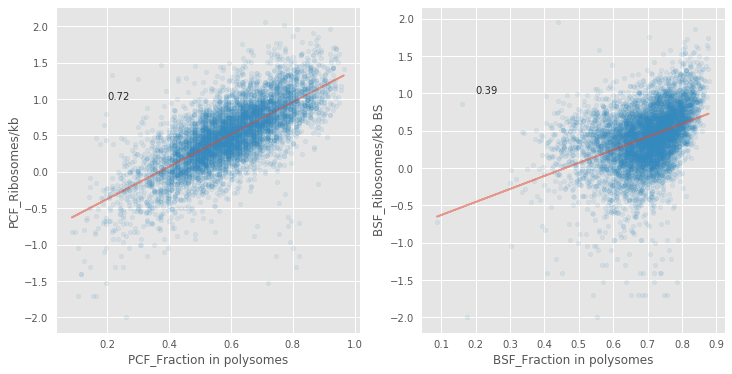

In [167]:
import scipy as sp
def plot_line(x,y,ax):
    linreg = sp.stats.linregress(x, y)
    ax.plot(x, linreg.slope*x + linreg.intercept,alpha=0.5)
    ax.text(0.2, 1, round(linreg.rvalue,2))

fig,axes=plt.subplots(figsize=(12,6),ncols=2)
ax=axes[1]
x='BSF_Fraction in polysomes'
y='BSF_Ribosomes/kb BS'
test.plot(x=x,
          y=y,kind='scatter',ax=ax,
         alpha=0.1)
plot_line(test[x],test[y],ax)
ax=axes[0]
x='PCF_Fraction in polysomes'
y='PCF_Ribosomes/kb'
test.plot(x='PCF_Fraction in polysomes',
          y='PCF_Ribosomes/kb',kind='scatter',ax=ax,
         alpha=0.1)
plot_line(test[x],test[y],ax)

In [168]:
TDdf2 = pd.concat([
        #Traslation Competent BSF
        ((out_df['B_pol_1']/0.7) / ((out_df['B_pol_1']/0.7) + (out_df['B_sub_1']/0.3))),
        ((out_df['B_pol_2']/0.7) / ((out_df['B_pol_2']/0.7) + (out_df['B_sub_2']/0.3))),
        ((out_df['B_pol_3']/0.7) / ((out_df['B_pol_3']/0.7) + (out_df['B_sub_3']/0.3))),
        #Traslation Competent PCF
        ((out_df['P_pol_1']/0.7) / ((out_df['P_pol_1']/0.7) + (out_df['P_sub_1']/0.3))),
        ((out_df['P_pol_2']/0.7) / ((out_df['P_pol_2']/0.7) + (out_df['P_sub_2']/0.3))),
        ((out_df['P_pol_3']/0.7) / ((out_df['P_pol_3']/0.7) + (out_df['P_sub_3']/0.3)))],
        #BSF vs PCF
         axis=1)


TDdf2.columns = ['B1','B2','B3','P1','P2','P3']
TDdf2['median_b']=TDdf2[['B1','B2','B3']].median(axis=1)
TDdf2['median_p']=TDdf2[['P1','P2','P3']].median(axis=1)
TDdf2.head()

,B1,B2,B3,P1,P2,P3,median_b,median_p
KS17gene_1000a,0.429277,0.438762,0.459723,0.419730,0.452208,0.441286,0.438762,0.441286
KS17gene_1005a,0.570349,0.507419,0.628542,0.467311,0.350963,0.424673,0.570349,0.424673
KS17gene_1009a,0.382161,0.454965,0.342551,0.440086,0.433017,0.538048,0.382161,0.440086
KS17gene_1016a,0.312854,0.329772,0.268391,0.311606,0.328532,0.296503,0.312854,0.311606
KS17gene_1022a,0.184014,0.188427,0.214506,0.263750,0.257882,0.252944,0.188427,0.257882


In [169]:
test=test.join(TDdf2[['median_b','median_p']]).replace(-np.inf,np.nan).replace(np.inf,np.nan).dropna()
test.head()

,BSF_Fraction in polysomes,PCF_Fraction in polysomes,BSF_Ribosomes/kb BS,PCF_Ribosomes/kb,median_b,median_p
Tb927.1.1000,0.615,0.585,0.164353,0.553883,0.345207,0.335254
Tb927.1.1010,0.703,0.475,0.451786,0.296665,0.289627,0.221675
Tb927.1.1020,0.724,0.450,0.468347,0.107210,0.372016,0.274321
Tb927.1.1030,0.596,0.445,0.000000,0.093422,0.157191,0.210353
Tb927.1.1050,0.755,0.665,0.167317,0.666518,0.528202,0.326010


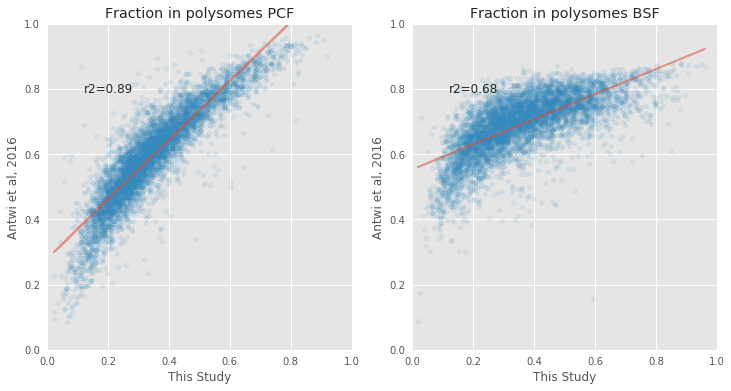

In [170]:
test=test.dropna()

fig,axes=plt.subplots(figsize=(12,6), ncols=2)

x='median_b'
y='BSF_Fraction in polysomes'
test.plot(x=x,
          y=y,kind='scatter',ax=axes[1],
          alpha=0.1)
UT.plot_line(test[x],test[y],axes[1])


axes[1].set_title('Fraction in polysomes BSF')
axes[1].set_xlim(0,1)
axes[1].set_ylim(0,1)
axes[1].set_ylabel('Antwi et al, 2016')
axes[1].set_xlabel('This Study')


x='median_p'
y='PCF_Fraction in polysomes'
test.plot(x=x,
          y=y,kind='scatter',ax=axes[0],
         alpha=0.1)
UT.plot_line(test[x],test[y],axes[0])


axes[0].set_title('Fraction in polysomes PCF')
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
axes[0].set_ylabel('Antwi et al, 2016')
axes[0].set_xlabel('This Study')

plt.savefig('Figures/Figure_6.png')
plt.show()

## riboseq comparison

In [171]:
ribo_df = pd.read_csv('InData/ribo_counts_927.txt',sep='\t',comment='#')
ribo_df.columns = list(ribo_df.columns)[0:6]+['ribo_BSF','ribo_PCF']
ribo_df[['ribo_BSF','ribo_PCF']]=np.log10(ribo_df[['ribo_BSF','ribo_PCF']])
ribo_df.set_index('Geneid',inplace=True)
ribo_df.head(5)

,Chr,Start,End,Strand,Length,ribo_BSF,ribo_PCF
Geneid,,,,,,,
Tb10.v4.0073,tryp_X-188b09.p2kB601,929,1489,+,561,-inf,-inf
Tb10.v4.0074,tryp_X-188b09.p2kB601,2775,3452,+,678,1.230449,-inf
Tb10.v4.0075,tryp_X-188b09.p2kB601,3781,5223,+,1443,-inf,-inf
Tb10.v4.0076,tryp_X-188b09.p2kB601,6264,7721,+,1458,-inf,-inf
Tb10.v4.0077,tryp_X-188b09.p2kB601,9669,10955,+,1287,-inf,-inf


In [172]:
out_df['B_tot'] = out_df[['B_tot_1','B_tot_2','B_tot_3']].median(axis=1)
out_df['P_tot'] = out_df[['P_tot_1','P_tot_2','P_tot_3']].median(axis=1)
out_df['B_sub'] = out_df[['B_sub_1','B_sub_2','B_sub_3']].median(axis=1)
out_df['P_sub'] = out_df[['P_sub_1','P_sub_2','P_sub_3']].median(axis=1)
out_df['B_pol'] = out_df[['B_pol_1','B_pol_2','B_pol_3']].median(axis=1)
out_df['P_pol'] = out_df[['P_pol_1','P_pol_2','P_pol_3']].median(axis=1)
mydata = np.log10(out_df[['B_tot','B_sub','B_pol','P_tot','P_sub','P_pol']])
mydata.tail(5)

,B_tot,B_sub,B_pol,P_tot,P_sub,P_pol
gene_Tb427.BES40.5,2.940563,3.218623,2.943782,0.368166,0.594239,0.428839
gene_Tb427.BES40.6,2.304518,2.504574,2.222302,-0.251622,0.005407,-0.041977
gene_Tb427.BES40.7,3.219919,2.571904,2.901011,1.248980,1.008868,1.028571
gene_Tb427.BES40.8,3.158120,3.442781,3.163677,1.234593,1.468801,1.131056
gene_Tb427.BES40.9,2.730842,2.780521,2.745694,0.084170,0.107996,-0.019734


In [173]:
merge=mydata.join(ribo_df,how='inner')

In [174]:
merge =merge.replace(-np.inf,np.nan).replace(np.inf,np.nan).dropna()

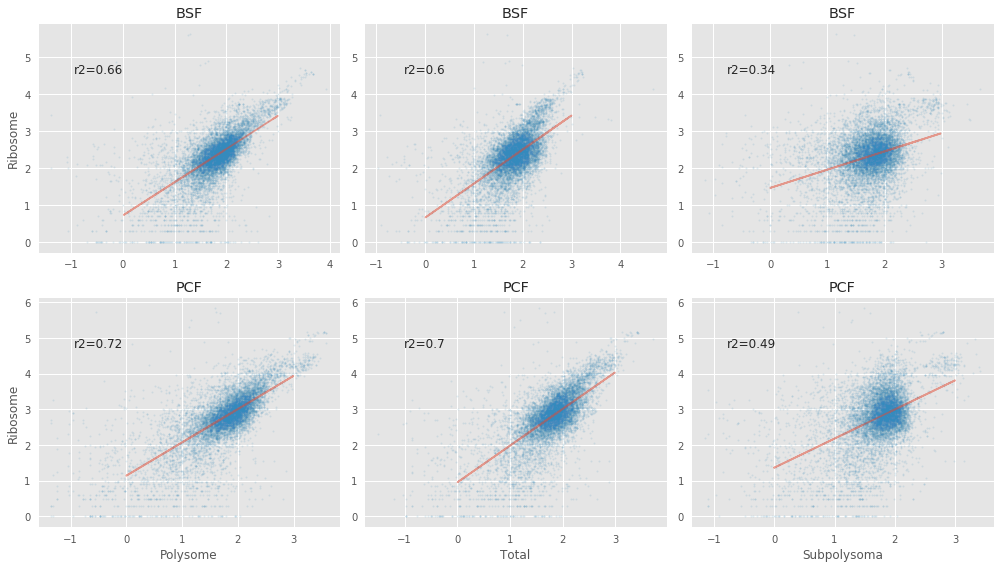

In [175]:
fig,axes=plt.subplots(ncols=3,nrows=2,figsize=(14,8))

merge.plot(kind='scatter',x='B_pol',y='ribo_BSF',ax=axes[0,0], alpha=0.1, s=2)
UT.plot_line(merge['B_pol'], merge['ribo_BSF'], axes[0,0],limits=(0,3))

merge.plot(kind='scatter',x='B_tot',y='ribo_BSF',ax=axes[0,1], alpha=0.1, s=2)
UT.plot_line(merge['B_tot'], merge['ribo_BSF'], axes[0,1],limits=(0,3))

merge.plot(kind='scatter', x='B_sub', y='ribo_BSF',ax=axes[0,2], alpha=0.1, s=2)
UT.plot_line(merge['B_sub'], merge['ribo_BSF'], axes[0,2],limits=(0,3))

merge.plot(kind='scatter',x='P_pol',y='ribo_PCF',ax=axes[1,0], alpha=0.1, s=2)
UT.plot_line(merge['P_pol'], merge['ribo_PCF'], axes[1,0],limits=(0,3))

merge.plot(kind='scatter',x='P_tot',y='ribo_PCF',ax=axes[1,1], alpha=0.1, s=2)
UT.plot_line(merge['P_tot'], merge['ribo_PCF'], axes[1,1],limits=(0,3))

merge.plot(kind='scatter', x='P_sub', y='ribo_PCF',ax=axes[1,2], alpha=0.1, s=2)
UT.plot_line(merge['P_sub'], merge['ribo_PCF'], axes[1,2],limits=(0,3))


axes[0,0].set_title('BSF')
axes[0,1].set_title('BSF')
axes[0,2].set_title('BSF')
axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[0,2].set_xlabel('')
axes[0,0].set_ylabel('Ribosome')
axes[0,1].set_ylabel('')
axes[0,2].set_ylabel('')


axes[1,0].set_title('PCF')
axes[1,1].set_title('PCF')
axes[1,2].set_title('PCF')
axes[1,0].set_xlabel('Polysome')
axes[1,1].set_xlabel('Total')
axes[1,2].set_xlabel('Subpolysoma')
axes[1,0].set_ylabel('Ribosome')
axes[1,1].set_ylabel('')
axes[1,2].set_ylabel('')

plt.tight_layout()
plt.savefig('Figures/Figure_7.png')
#merge.plot(kind='scatter',x='B_tot',y='ribo_BSF')
#merge.plot(kind='scatter',x='B_sub',y='ribo_BSF')